In [1]:
import pathlib as pl
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
import numpy as np 
import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import pathlib as pl
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import seaborn as sns
from copy import deepcopy
import sklearn
from sklearn.metrics import mutual_info_score 
import rcca

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler


### dice

In [2]:
def dice_coef(truth, pred, smooth=1):
    
    true_flat = tf.reshape(truth, [-1])
    pred_flat = tf.reshape(pred, [-1])
    
    intersection = tf.reduce_sum(true_flat*pred_flat)
    return ((2. * intersection)+smooth) / (tf.reduce_sum(true_flat)+tf.reduce_sum(pred_flat) + smooth)


def dice_coef_loss(gt, pred):
    return 1-dice_coef(gt, pred)

# model

In [3]:
shrink = 8

In [4]:
def unet(pretrained_weights = None,input_size = (240,240,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64/shrink, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64/shrink, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss =dice_coef_loss, metrics = [dice_coef])

    return model


In [5]:
bad = unet()

In [6]:
good = unet()

# get paths to weights

In [7]:
base = pl.Path.cwd().parent.parent.parent.parent.parent.parent \
        / "nfs" / "masi" / "remedilw" / "class" / "vis" /"vis_proj"


In [8]:
f_dir = base /"weights"

In [9]:
bad_w = f_dir/'weights00000200.h5'
good_w = f_dir/"weights00001000.h5"

# load weights

In [10]:
bad.load_weights(bad_w)

In [11]:
good.load_weights(good_w)

# load input images

In [12]:
img_path = base / "imgs_and_labels"

In [13]:
test_X = np.load(img_path/"test_X.npy")

In [14]:
image = test_X[7,:,:,0] # loading first image shape(240,240)
image = np.expand_dims(image,axis=0) #shape (1,240,240)

# function to show the feature maps at a given layer

In [15]:
def fm(model, layer, image):

    model = Model(inputs=model.inputs,outputs=model.layers[layer].output) # getting output from layer, layer
    feature_maps = model.predict(image) # shape same as layer output (1, 30, 30,64)
    return feature_maps

### get the Conv Layer indices

In [16]:
len(bad.layers)

39

In [17]:
len(bad.get_weights())

48

In [18]:
layers = [1, 2, 4, 5, 7, 8, 10, 11, 14, 15, 18, 20, 21, 23, 25, 26, 28, 30, 31, 33, 35, 36, 37, 38]

In [19]:
len(layers)

24

### hide retracing warnings, unimportant

In [20]:
tf.get_logger().setLevel('ERROR')

# plot the outputs

In [21]:
test_X.shape

(20, 240, 240, 1)

In [22]:
# def get_feat_maps(model, test_X, layers, converged=None):
    
#     if converged==None:
#         print("Specify which model")
#         return
    
#     for img_idx, image in tqdm(enumerate(test_X), total=len(test_X)):
        
#         image = image[:,:,0]
#         image = np.expand_dims(image,axis=0)        
        
#         for lay_idx, lay in tqdm(enumerate(layers), total=len(layers)):

#             fms = fm(model, layer=lay, image=image)
#             fms = np.reshape(fms, fms.shape[1:])

#             fms = np.mean(fms, axis=2)
#             plt.imshow(fms, vmin=fms.min(), vmax=fms.max(), cmap="gray")
#             plt.axis("off")
#             #plt.show()
            
#             if img_idx < 10:
#                 s_img_idx = "0" + str(img_idx)
#             else:
#                 s_img_idx = str(img_idx)
                
#             if lay_idx < 10:
#                 s_lay_idx = "0" + str(lay_idx)
#             else:
#                 s_lay_idx = str(lay_idx)
            
#             if converged:
#                 plt.savefig(savepath/"converged_{}_image_{}_layer_avg_feature_map.png".format(s_img_idx, s_lay_idx), dpi=300)
#             else:
#                 plt.savefig(savepath/"partial_{}_image_{}_layer_avg_feature_map.png".format(s_img_idx, s_lay_idx), dpi=300)



In [23]:
def normalize(filters):

    # if it's a scalar ignore
    if filters.shape == (1,1):
        pass
    
    else:
        filters = deepcopy(filters)

        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)
    return filters

In [24]:
def MSE(a, b):
    
    mse = tf.keras.losses.MSE(normalize(a).flatten(), 
                                  normalize(b).flatten())


        
    return (np.round(mse.numpy(), 5))

In [25]:
plt.rcParams["font.family"] = "serif"


In [26]:
savepath = pl.Path.cwd() / "feature_maps"

In [27]:
def get_feat_maps(test_X, layers, good, bad):
    
    for img_idx, image in tqdm(enumerate(test_X), total=len(test_X)):
        
        image = image[:,:,0]
        image = np.expand_dims(image,axis=0)        
        
        for lay_idx, lay in tqdm(enumerate(layers), total=len(layers)):

            # feature map
            good_fms = fm(good, layer=lay, image=image)
            good_fms = np.reshape(good_fms, good_fms.shape[1:])
            good_fms = np.mean(good_fms, axis=2)
            
            bad_fms = fm(bad, layer=lay, image=image)
            bad_fms = np.reshape(bad_fms, bad_fms.shape[1:])
            bad_fms = np.mean(bad_fms, axis=2)
            
            
            # scale
#             sc = StandardScaler(with_mean=True, with_std=True)
#             sc_good_fms = sc.fit_transform(good_fms)

#             sc = StandardScaler(with_mean=True, with_std=True)
#             sc_bad_fms = sc.fit_transform(bad_fms)
            
            
#             # CCA
#             nComponents = 2 # min(p,q) components
#             cca = rcca.CCA(kernelcca = False, reg = 0.2, numCC = nComponents,)
#             cca.train([sc_good_fms, sc_bad_fms])
#             #print('Canonical Correlation Per Component Pair:',cca.cancorrs)
#             #print('% Shared Variance:',cca.cancorrs**2)
#             cca = cca.cancorrs[0]


            mse = MSE(good_fms, bad_fms)
            
            
            # Plot     

            
            
#             f,(ax1,ax2, axcb) = plt.subplots(1,3, 
#                 gridspec_kw={'width_ratios':[3,3,0.08]})
            
            f,(ax1,ax2) = plt.subplots(1,2, 
                gridspec_kw={'width_ratios':[3,3,]})
            f.set_figwidth(10)
            f.set_figheight(5)
            f.suptitle("MSE "+str(np.round(mse, 5)), size=20, y=-0.01)




            ax1.get_shared_y_axes().join(ax2)
            ax1.imshow(bad_fms, vmin=bad_fms.min(), vmax=bad_fms.max(), cmap="gray")
            ax1.set_title("Partially Trained")
            ax2.imshow(good_fms, vmin=good_fms.min(), vmax=good_fms.max(), cmap="gray")
            ax2.set_title("Fully Trained")
            
            
            ax1.set_yticks([])
            ax1.set_xticks([])
            ax2.set_yticks([])
            ax2.set_xticks([])
                        
            
            
            #plt.show()
            
            if img_idx < 10:
                s_img_idx = "0" + str(img_idx)
            else:
                s_img_idx = str(img_idx)
                
            if lay_idx < 10:
                s_lay_idx = "0" + str(lay_idx)
            else:
                s_lay_idx = str(lay_idx)
                
            plt.savefig(savepath/"{}_image_{}_layer_avg_feature_map_mse.png".format(s_img_idx, s_lay_idx), 
                        dpi=300,
                        bbox_inches='tight')

            

/home-local/remedilw/programs/anaconda/envs/lvo_remedilw/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


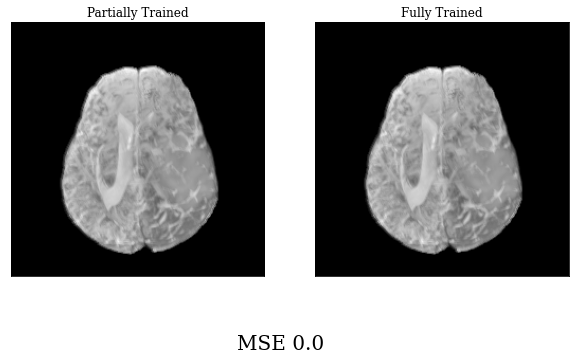

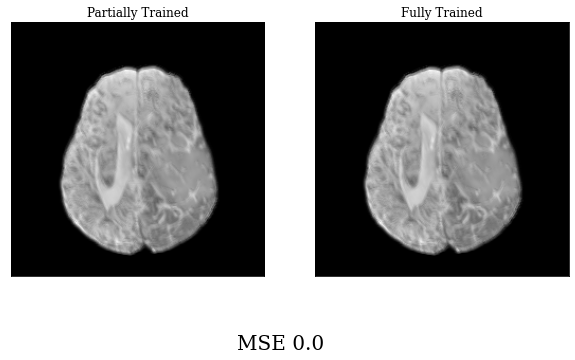

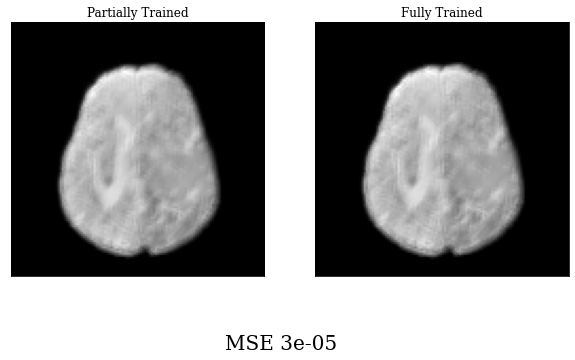

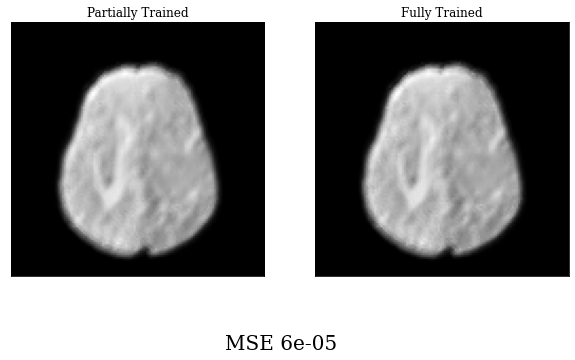

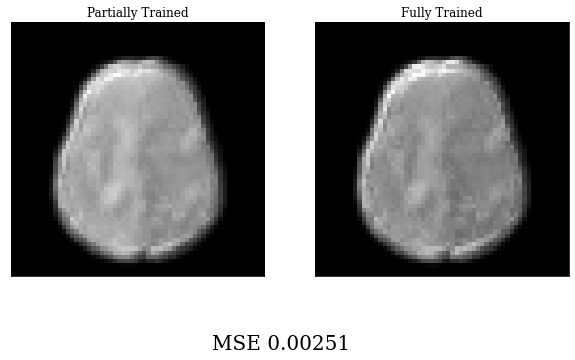

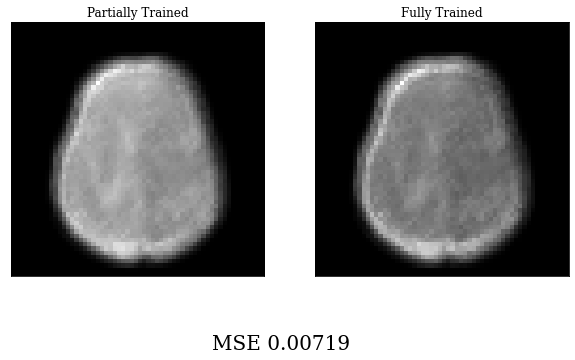

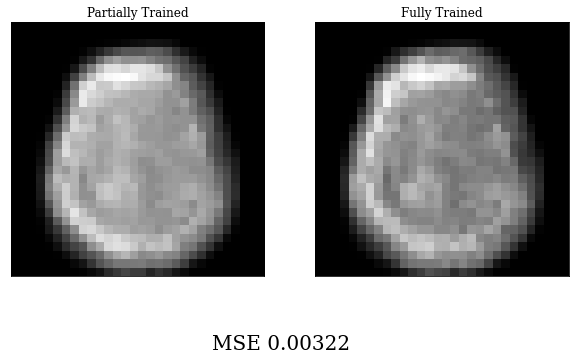

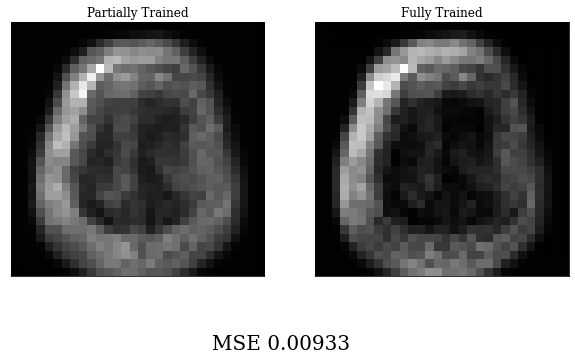

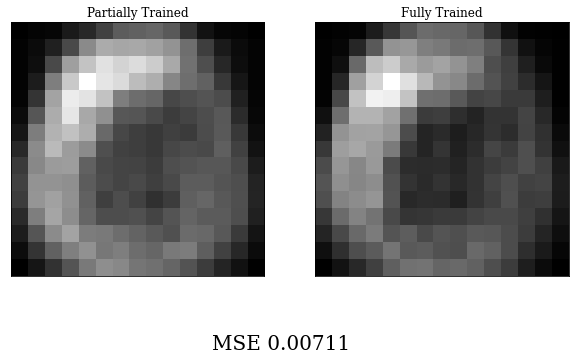

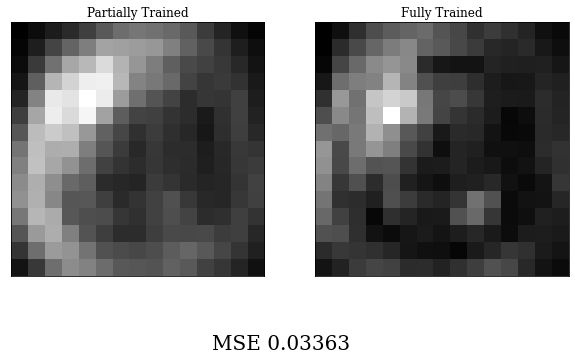

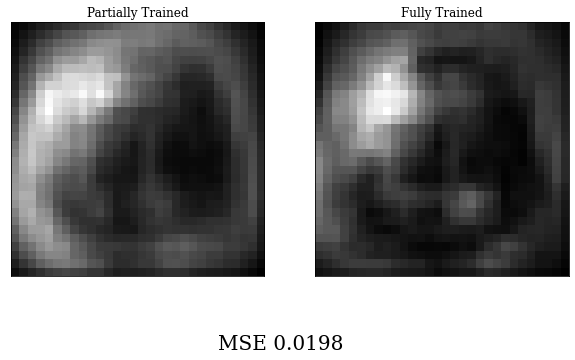

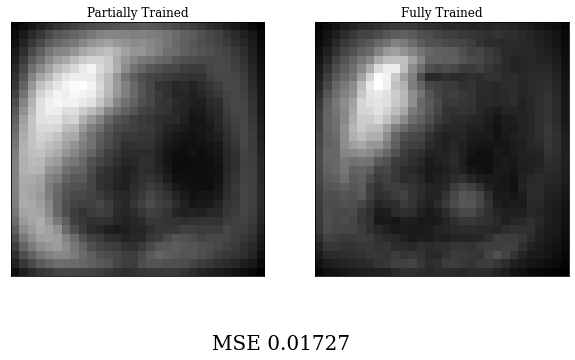

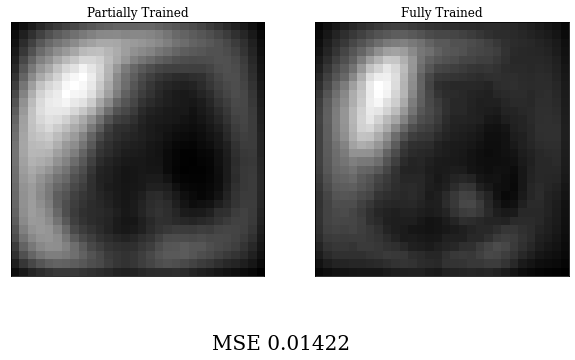

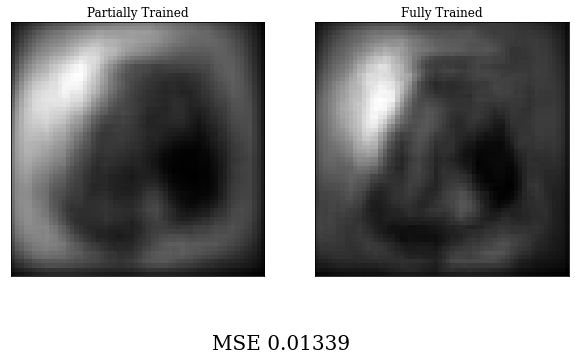

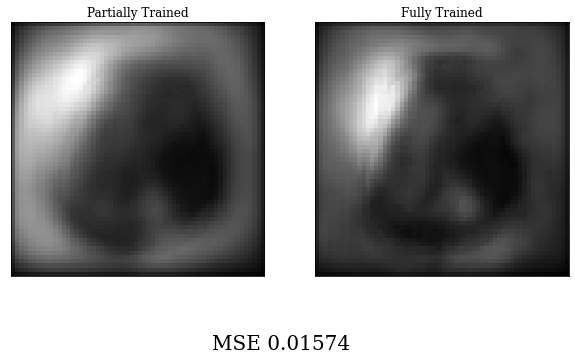

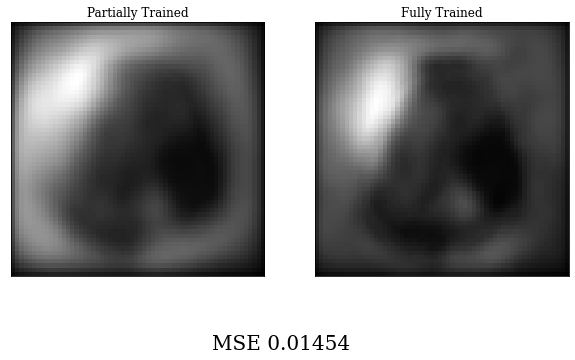

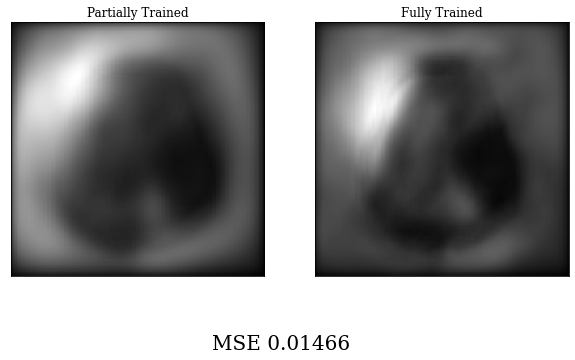

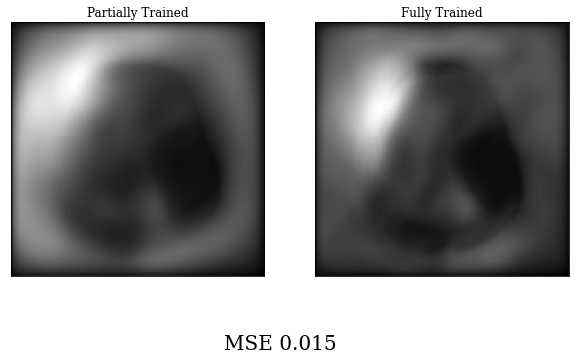

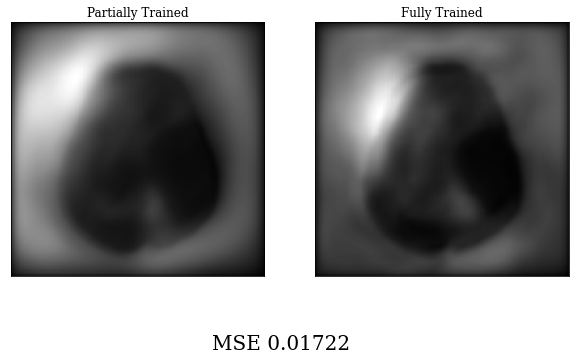

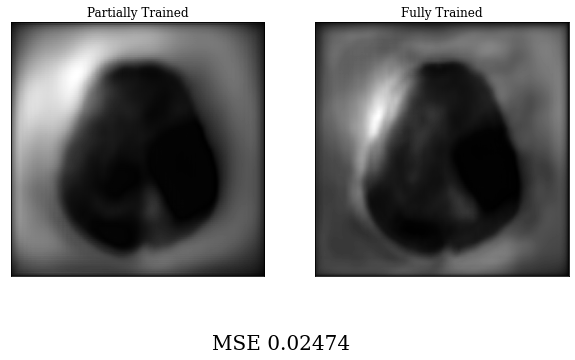

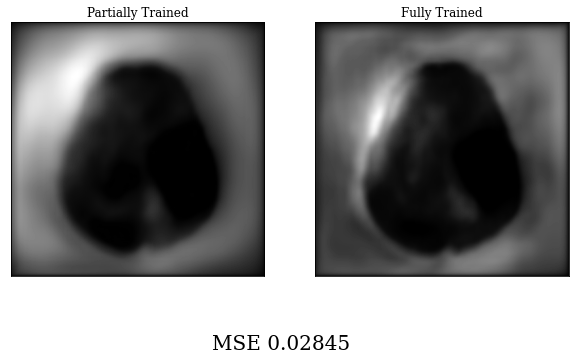

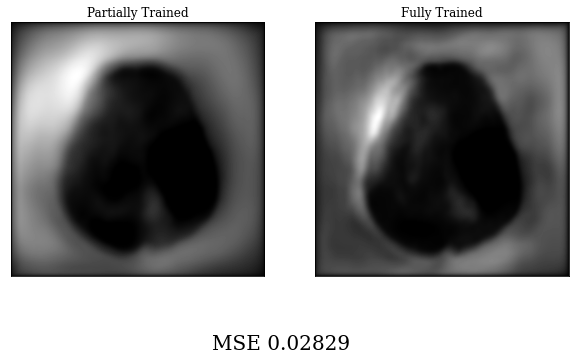

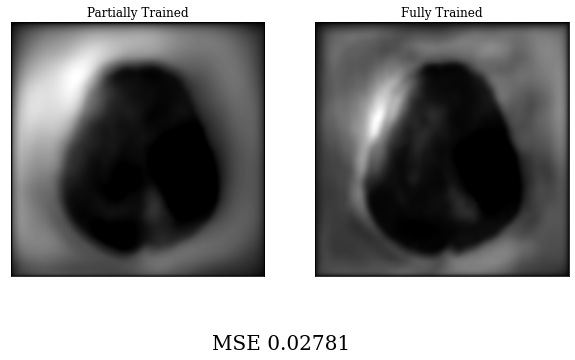

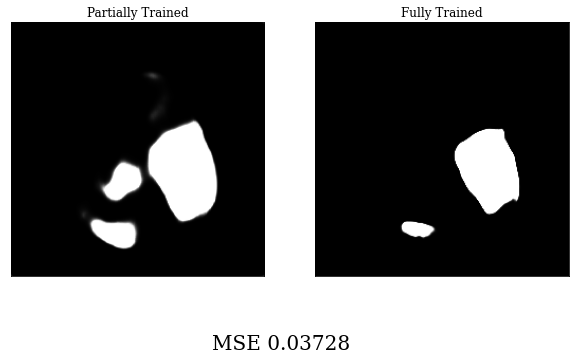

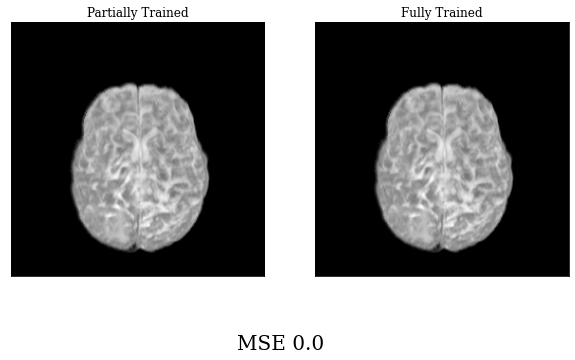

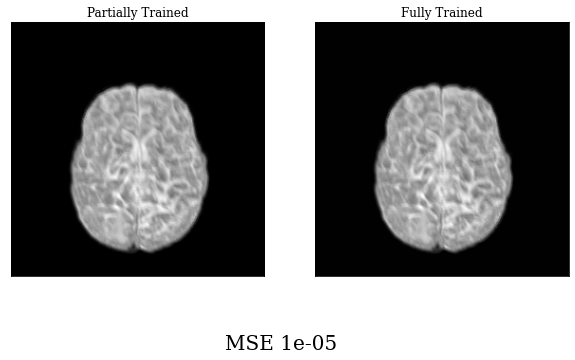

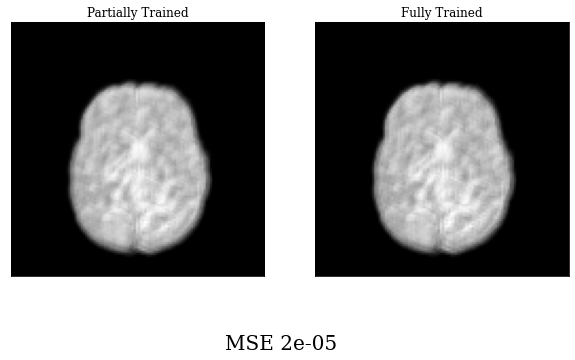

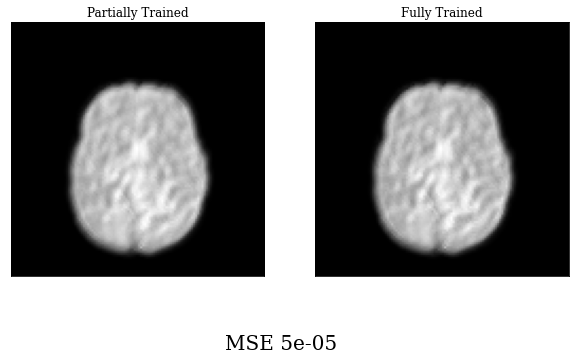

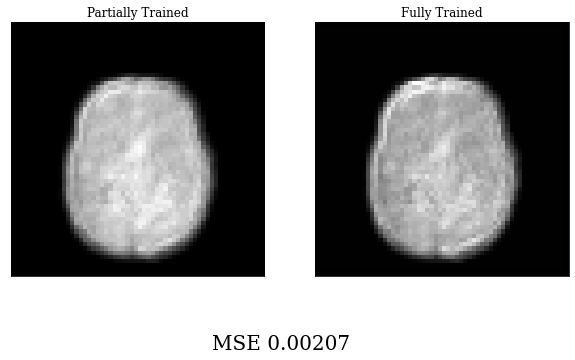

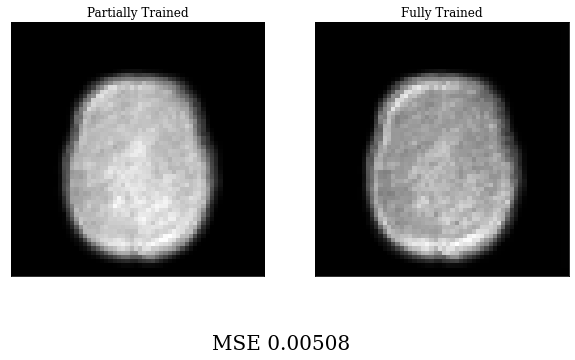

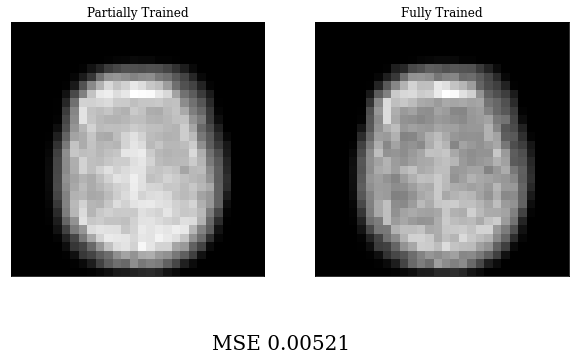

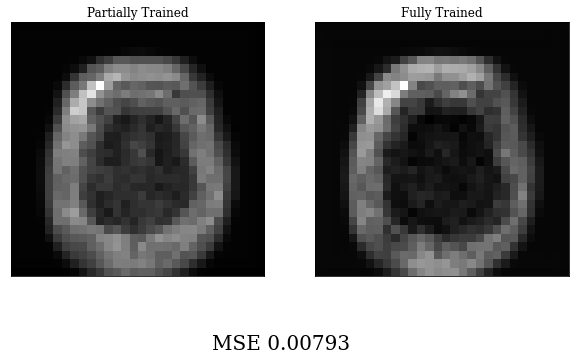

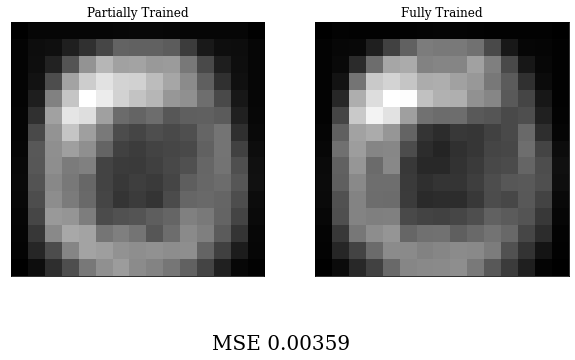

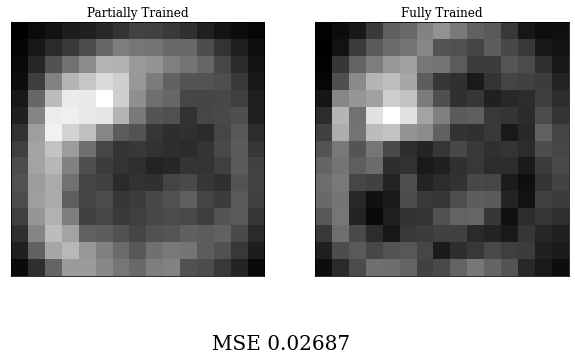

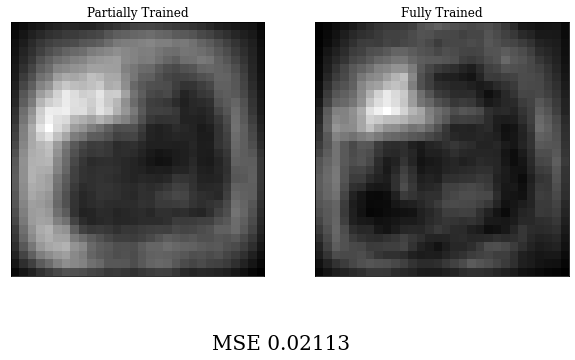

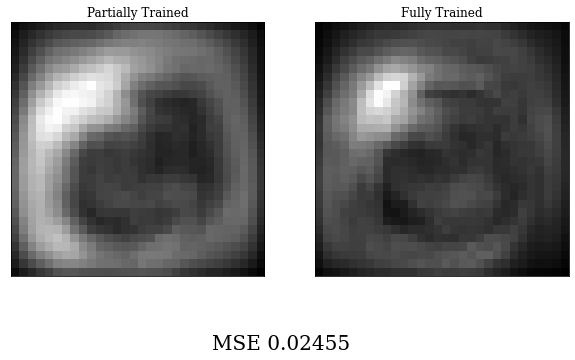

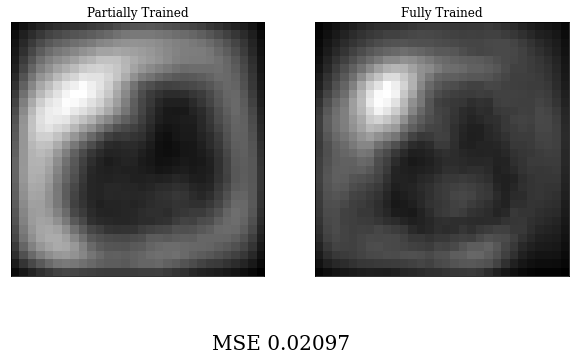

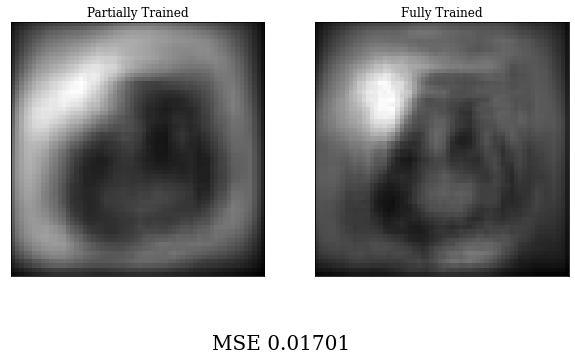

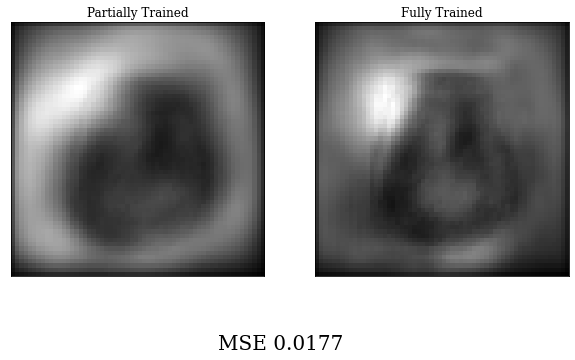

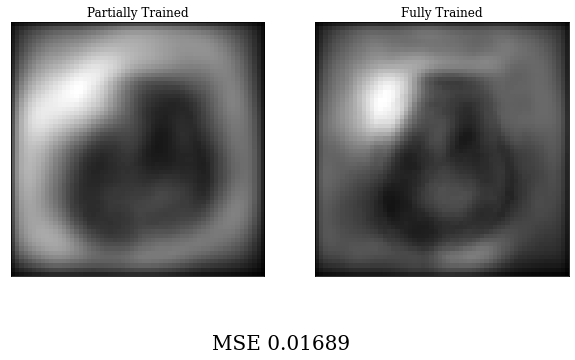

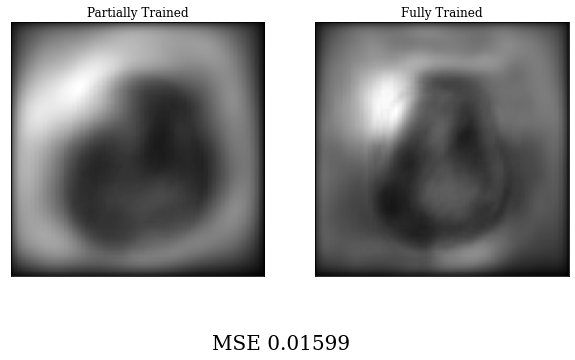

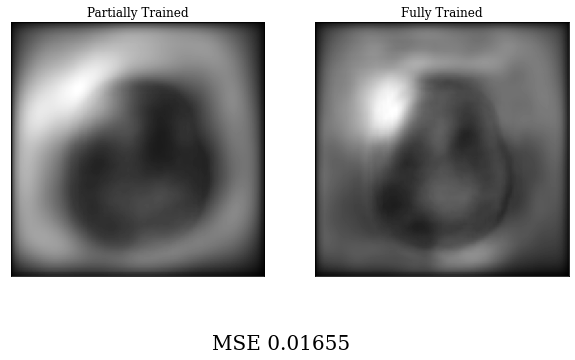

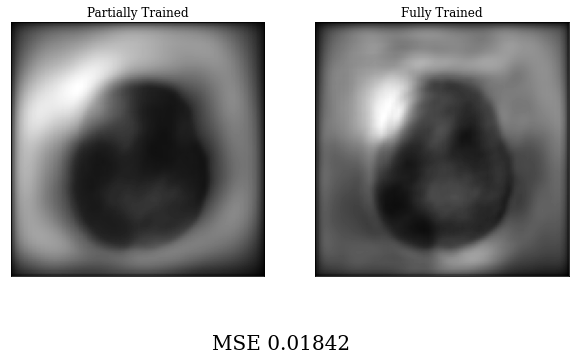

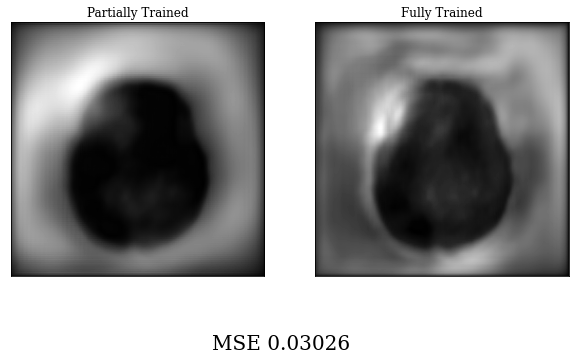

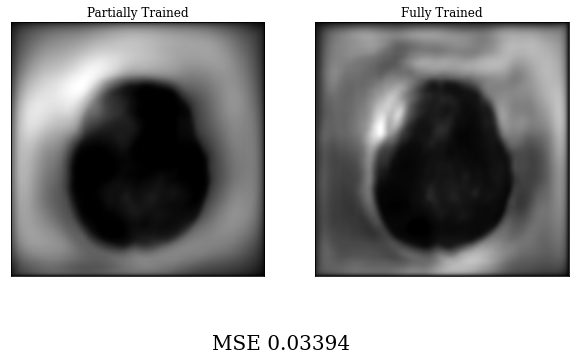

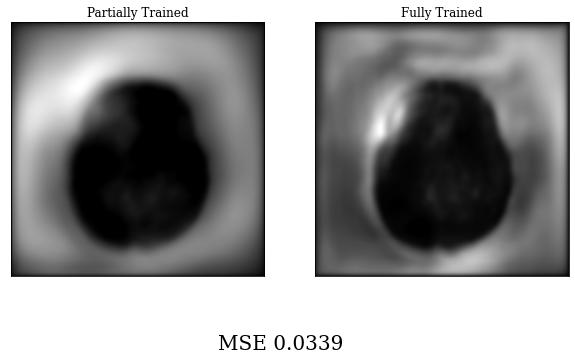

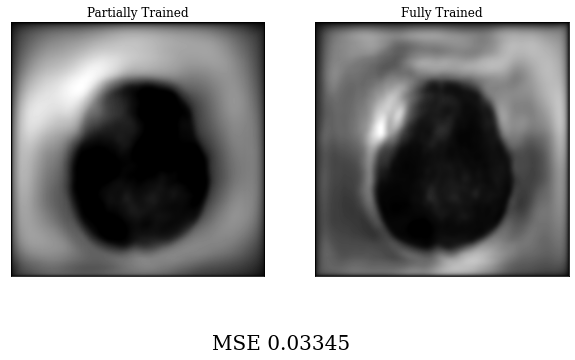

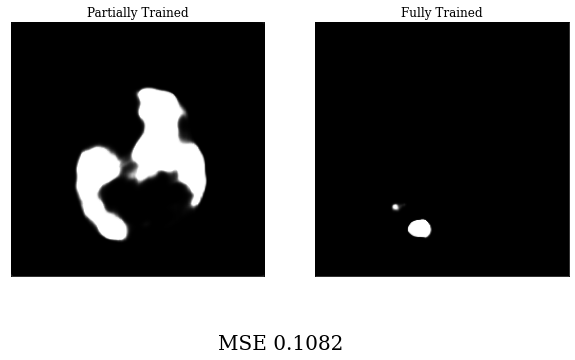

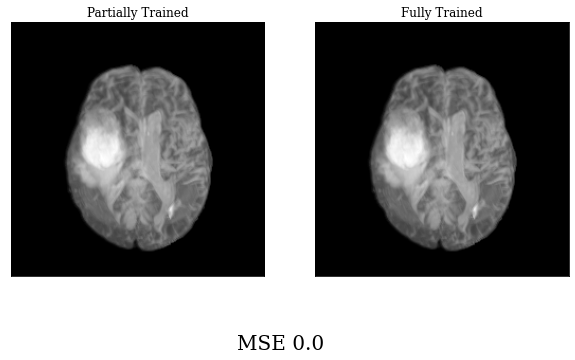

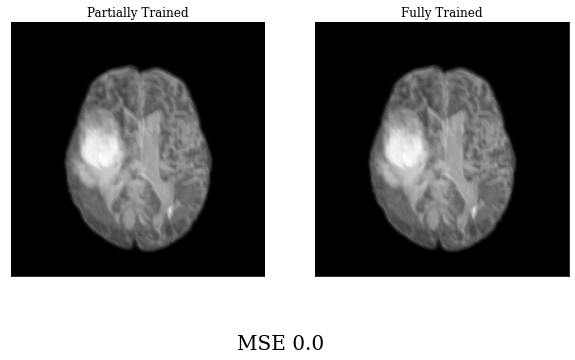

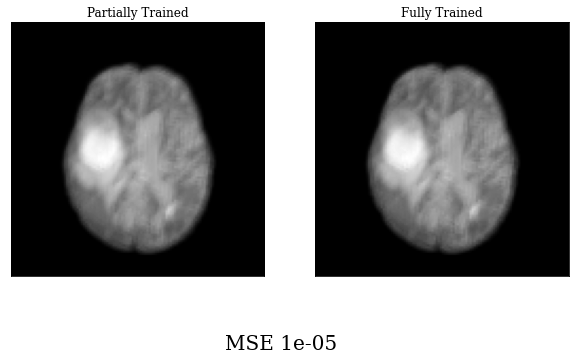

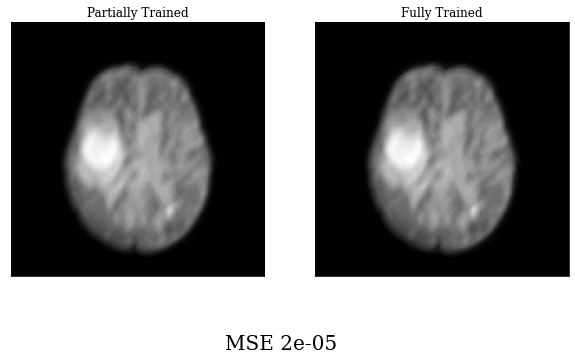

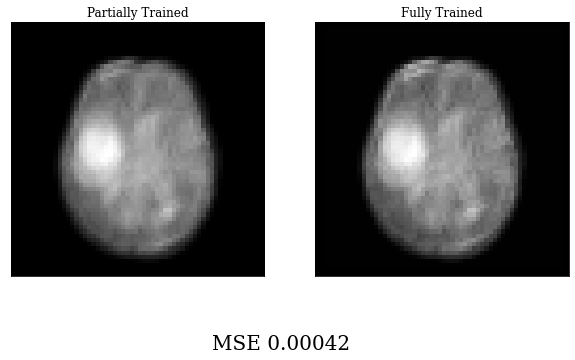

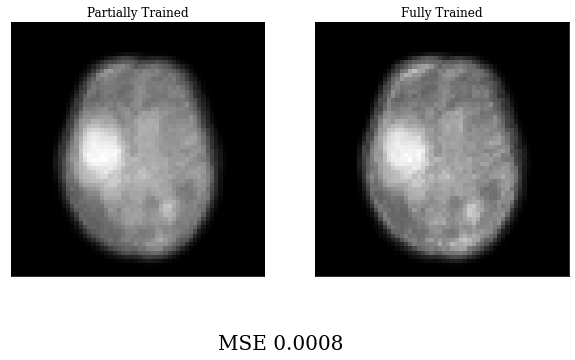

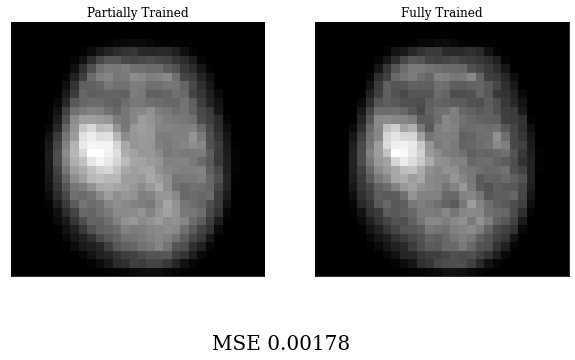

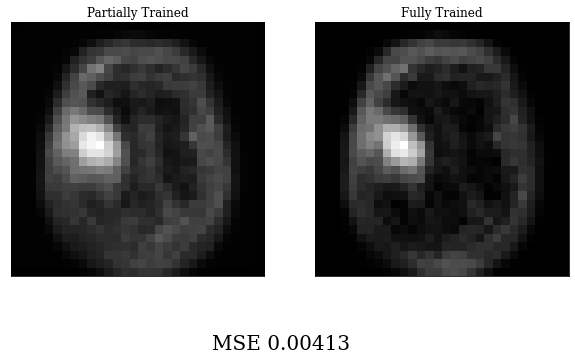

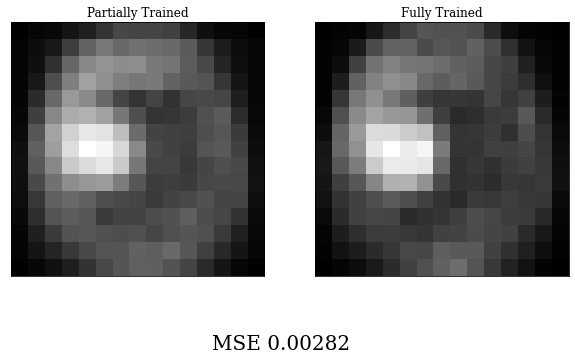

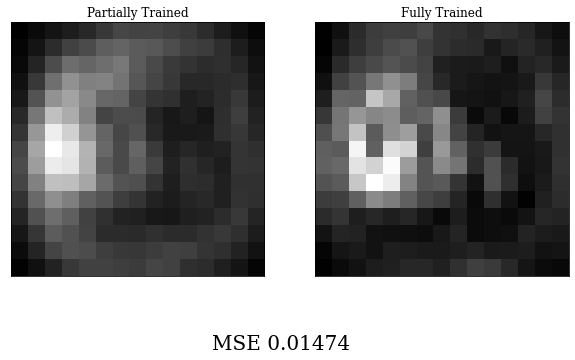

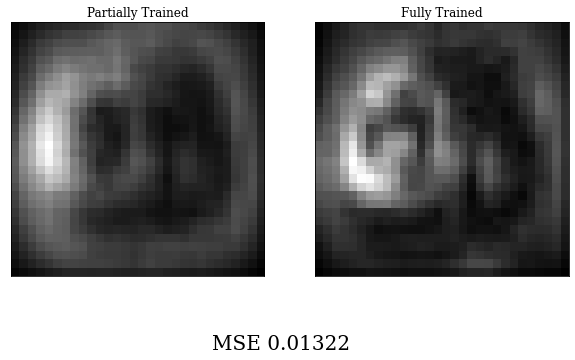

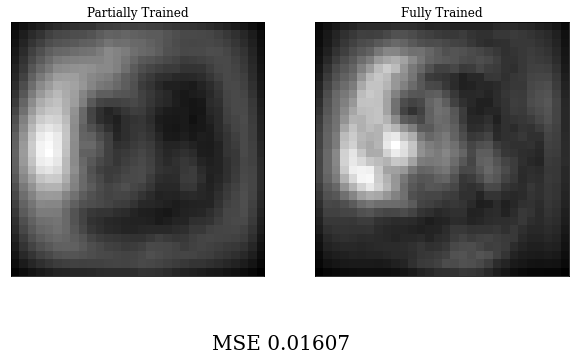

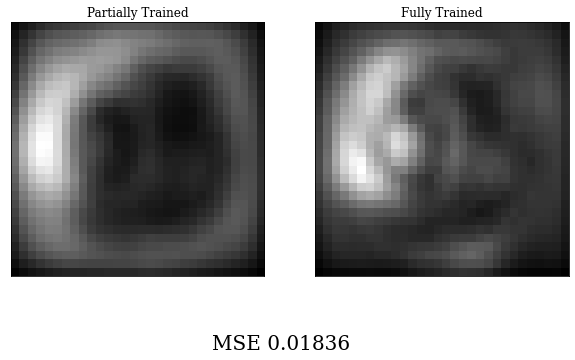

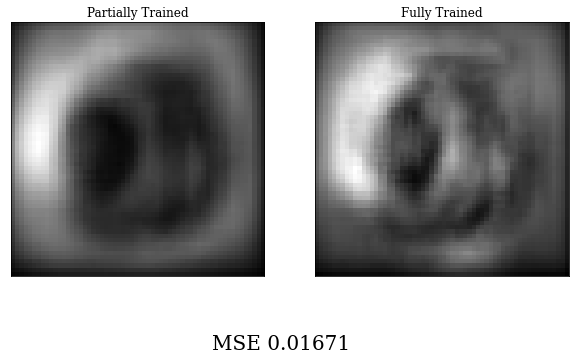

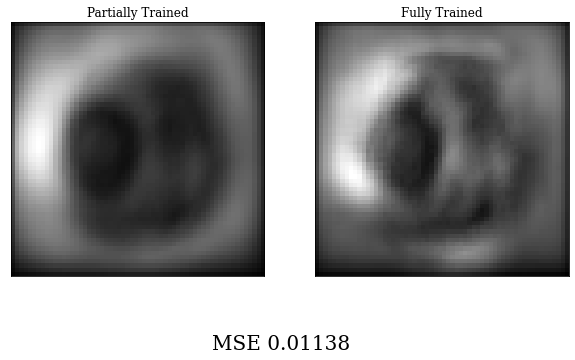

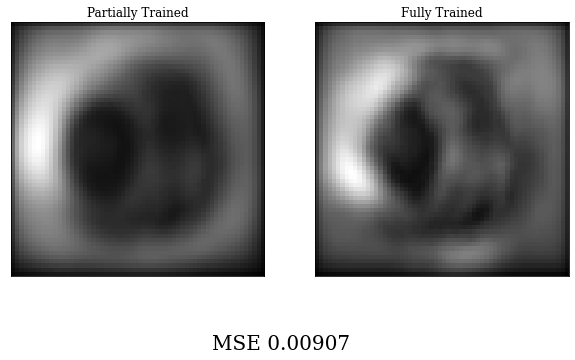

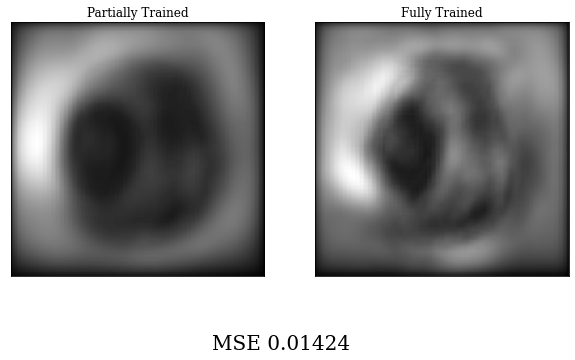

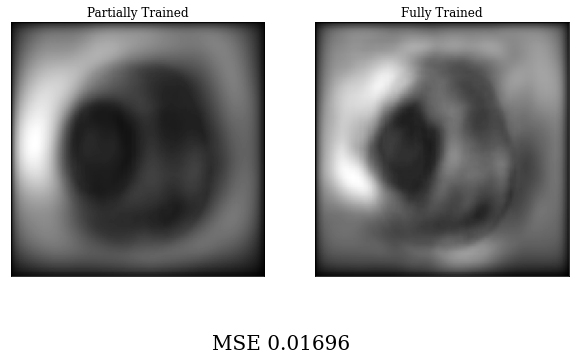

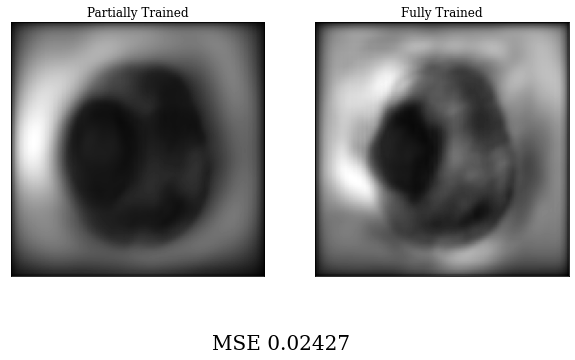

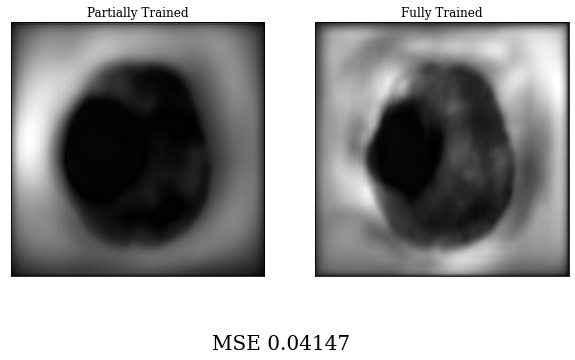

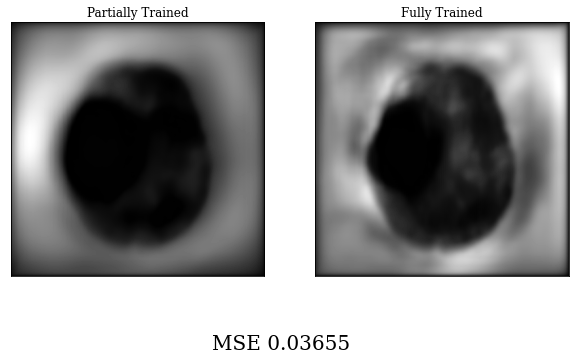

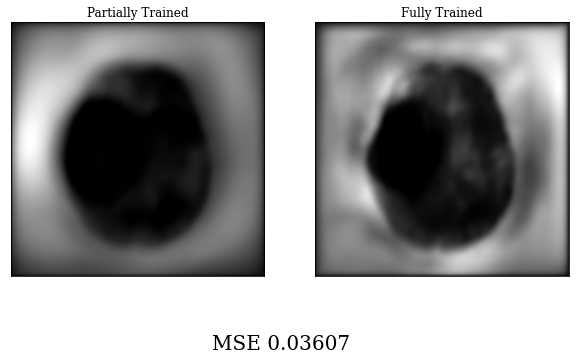

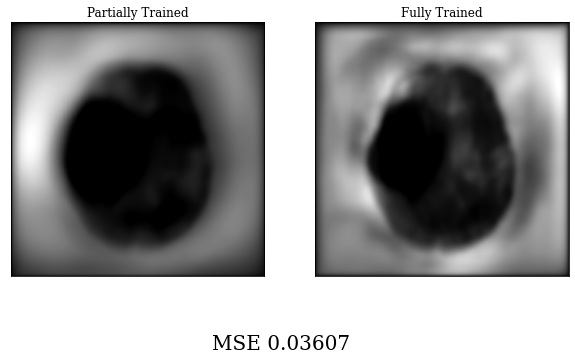

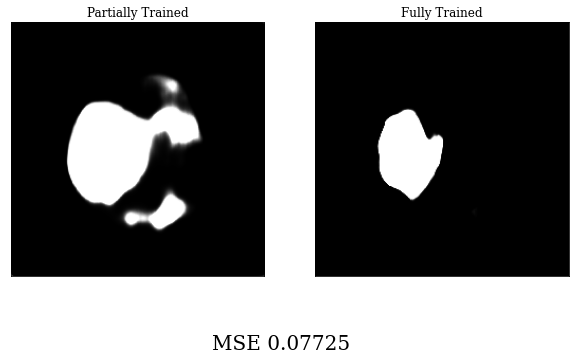

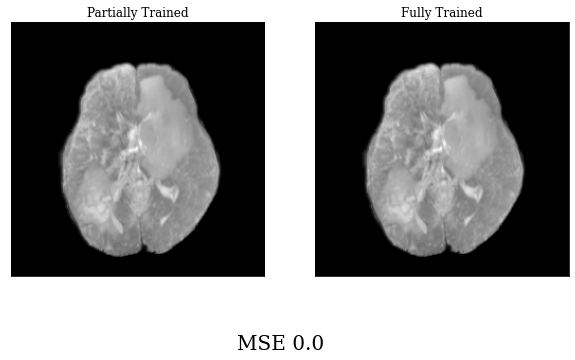

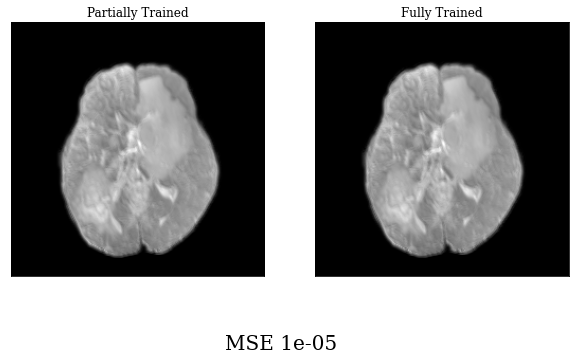

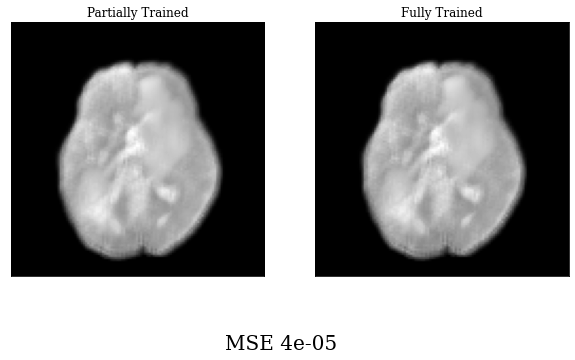

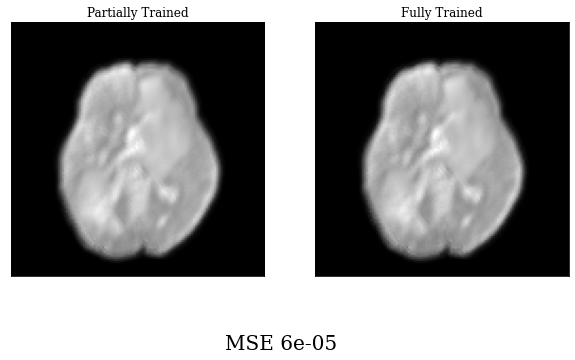

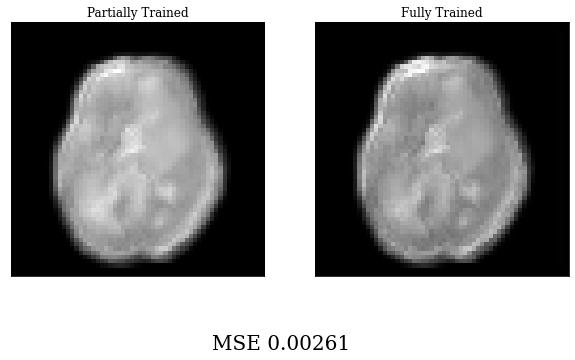

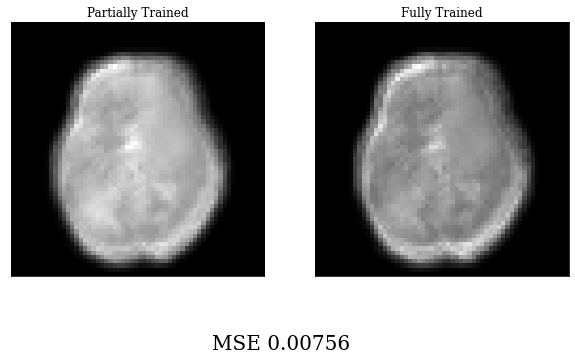

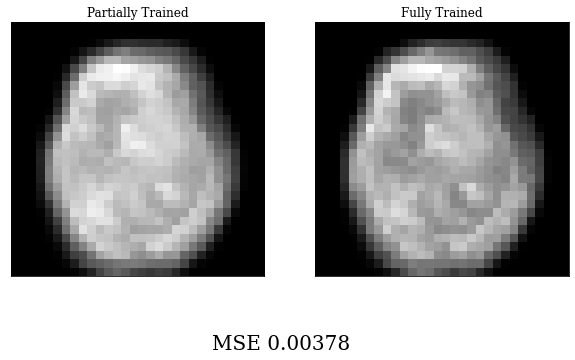

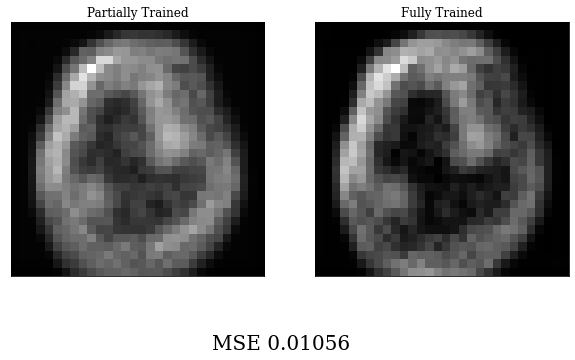

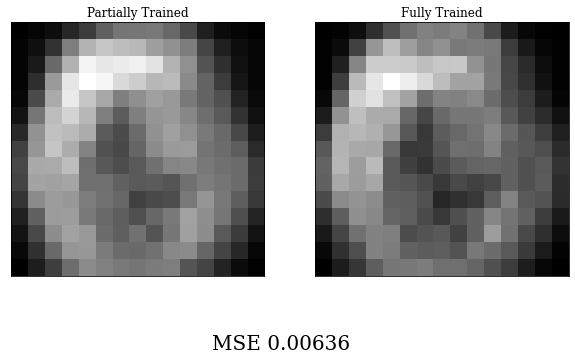

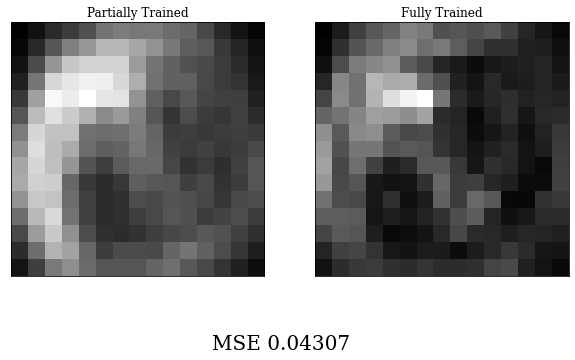

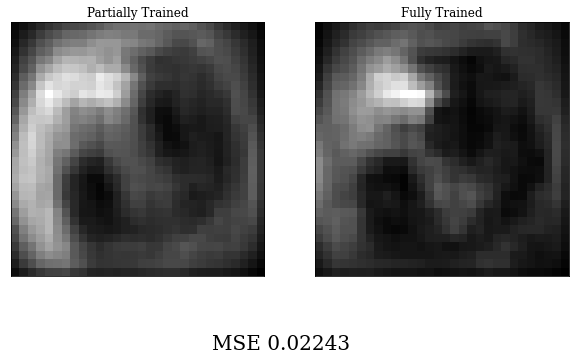

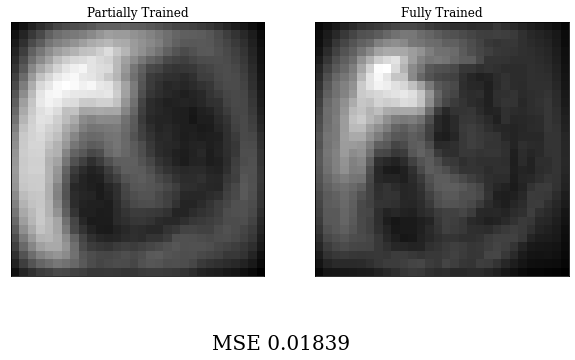

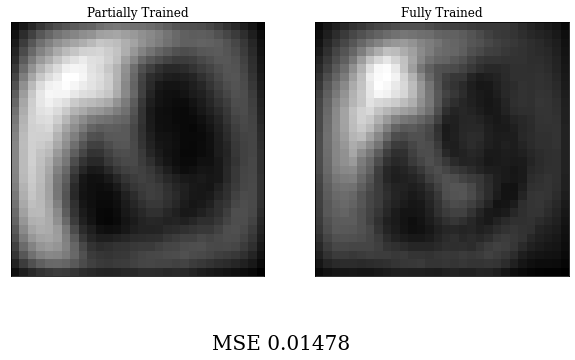

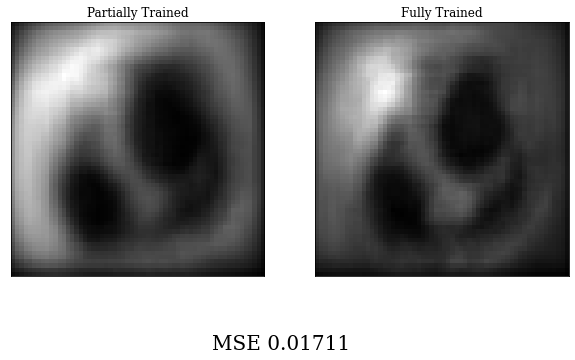

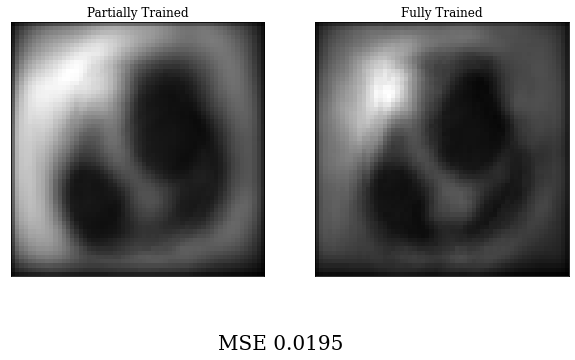

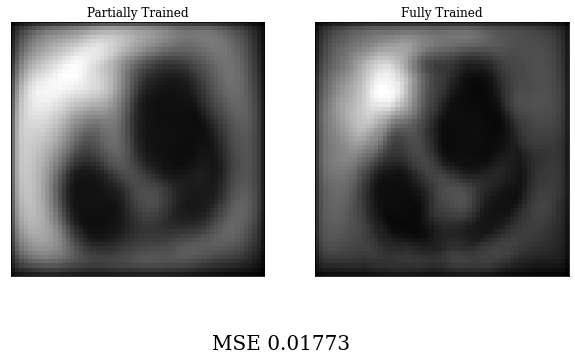

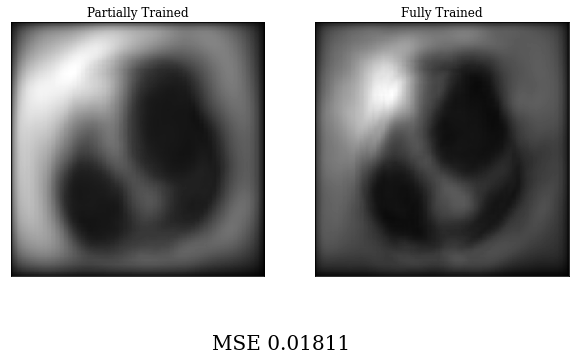

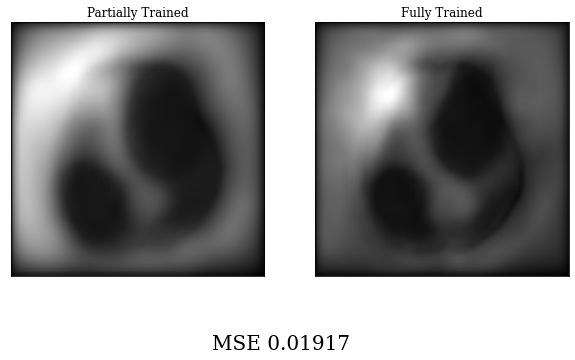

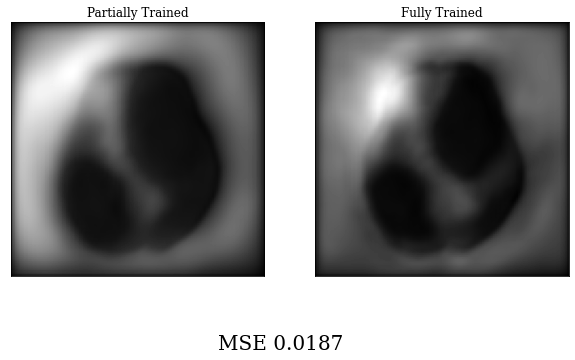

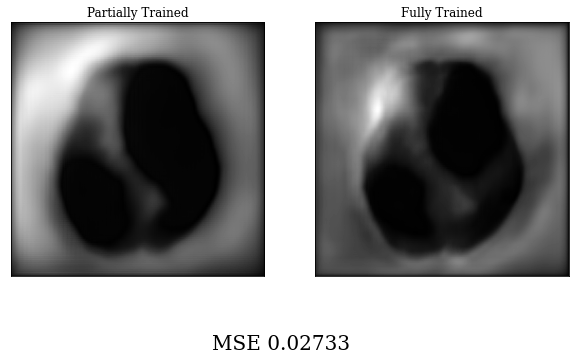

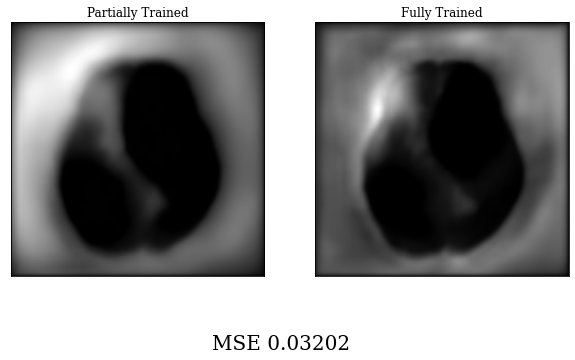

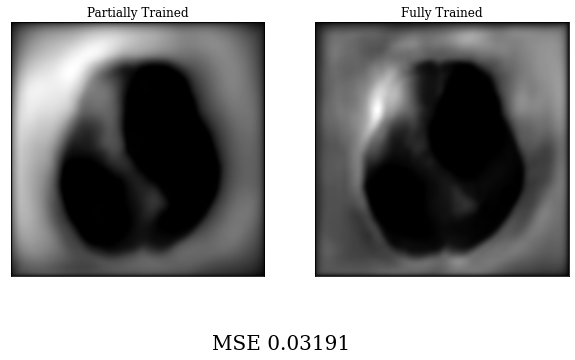

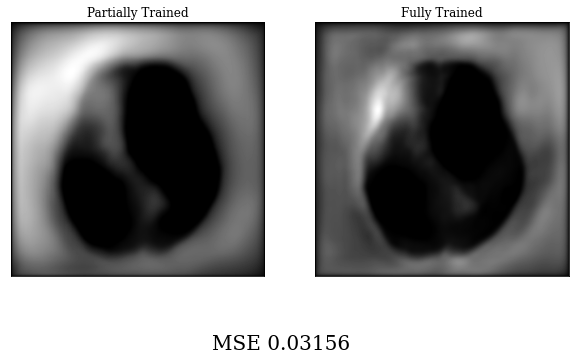

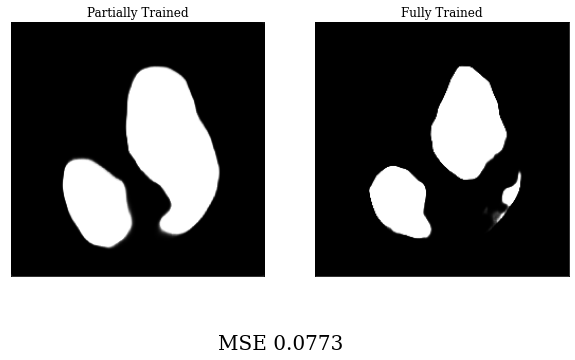

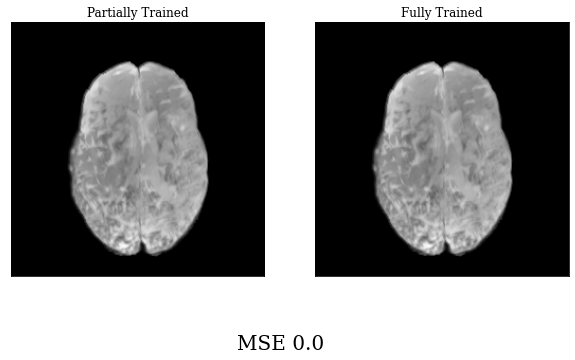

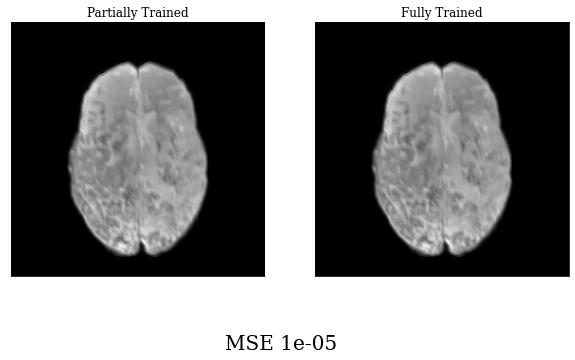

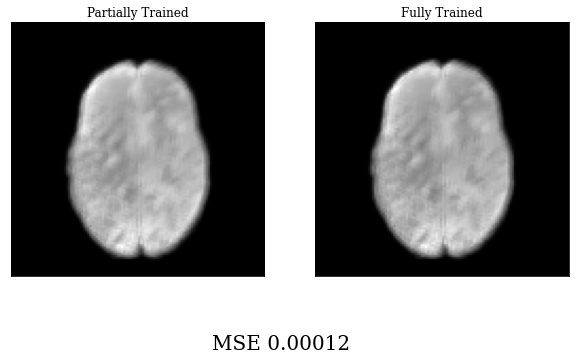

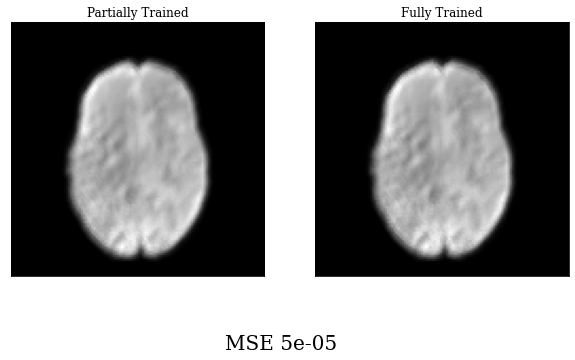

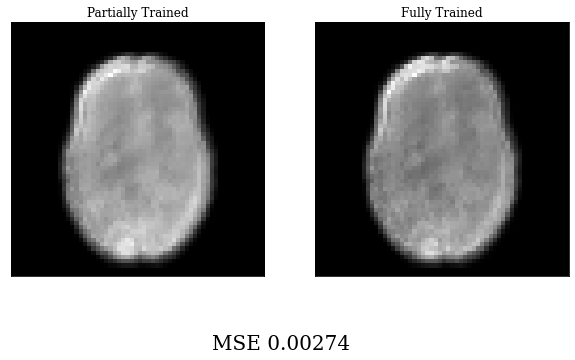

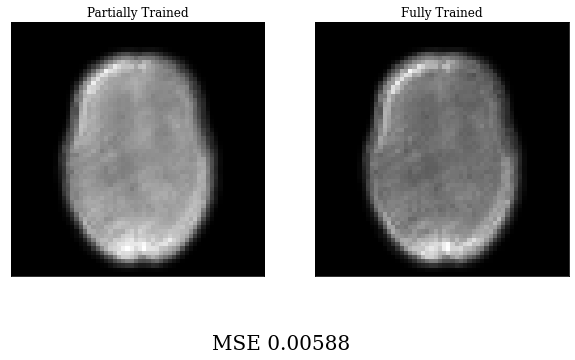

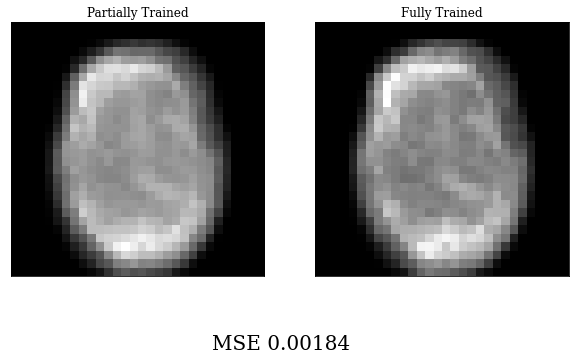

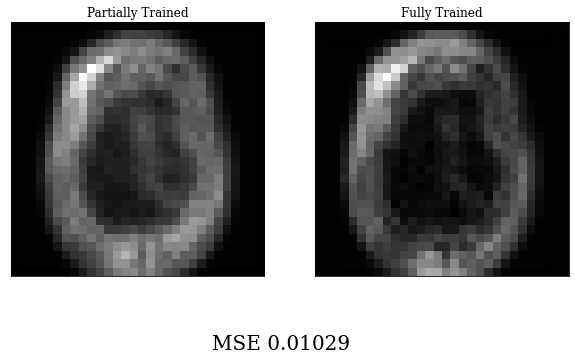

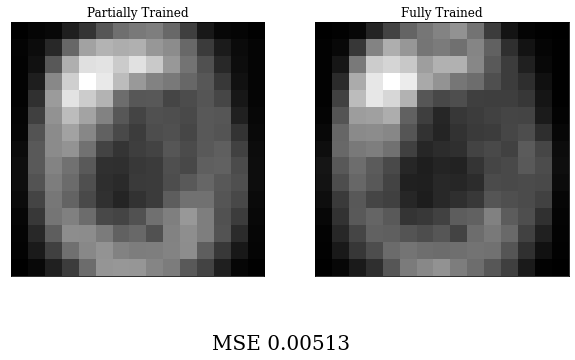

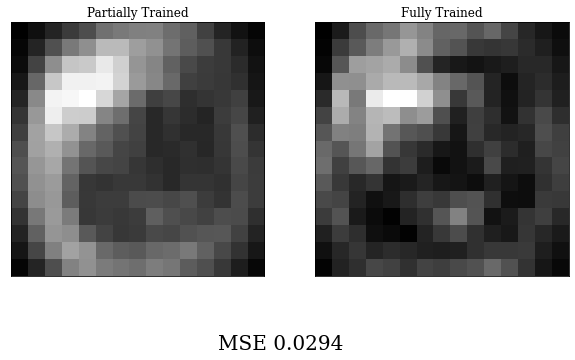

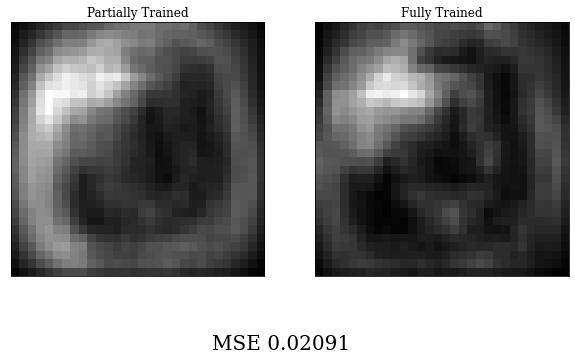

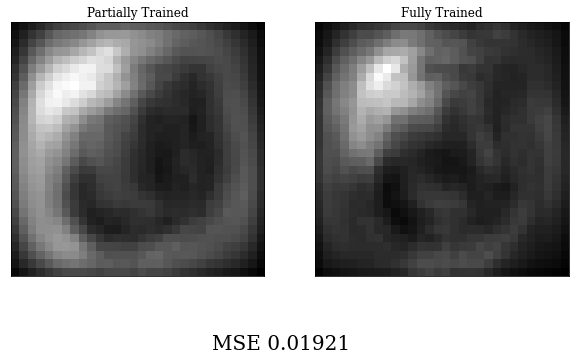

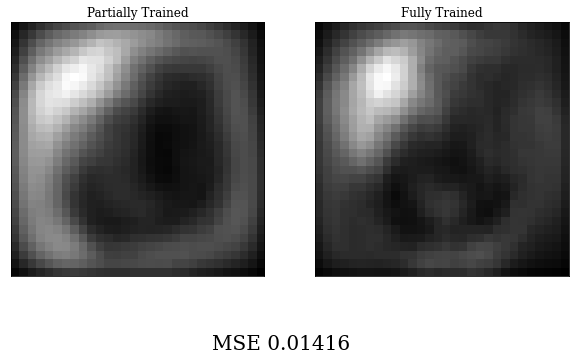

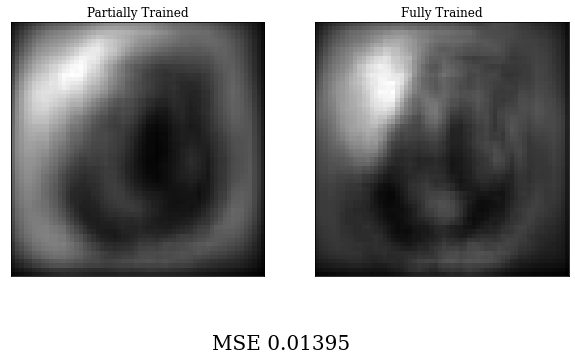

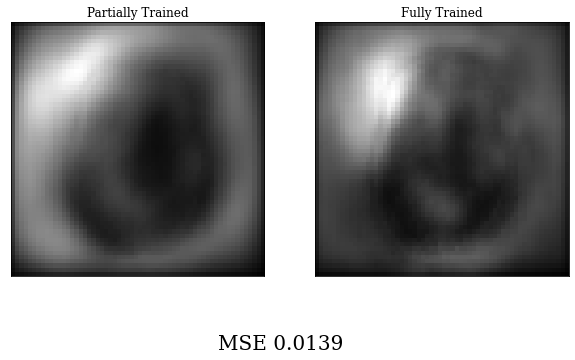

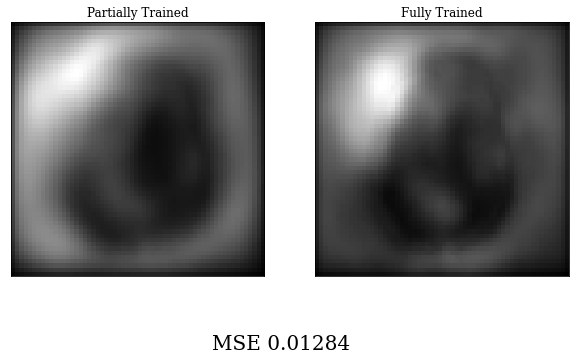

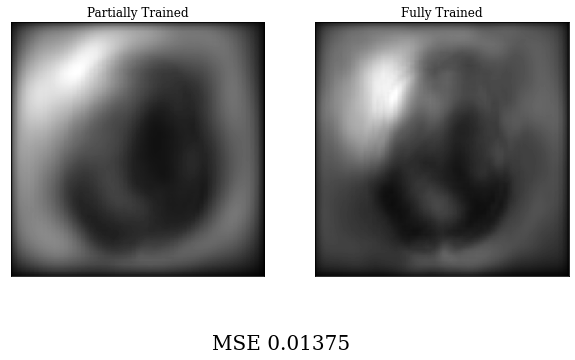

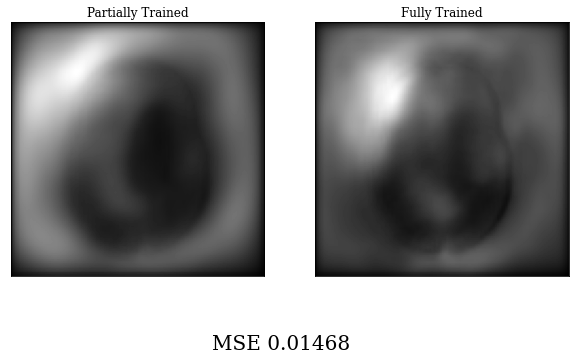

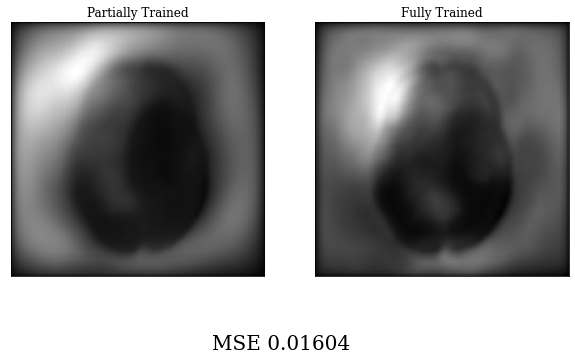

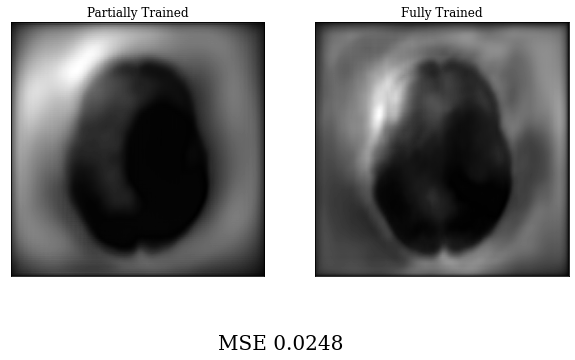

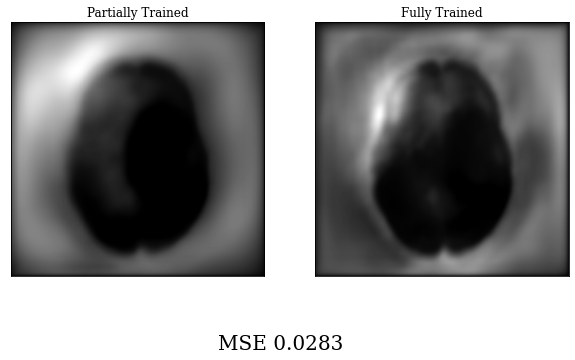

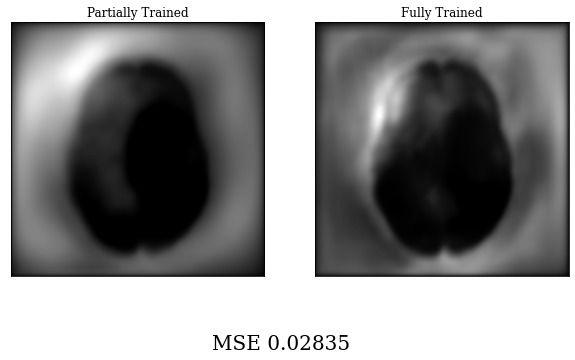

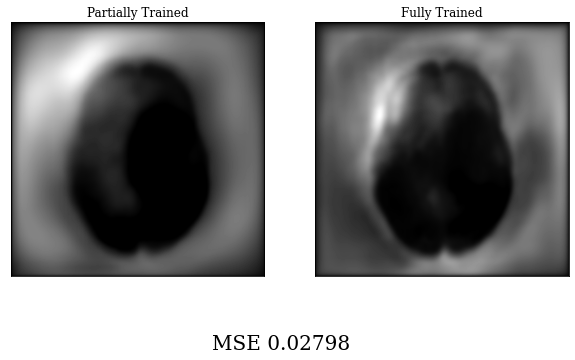

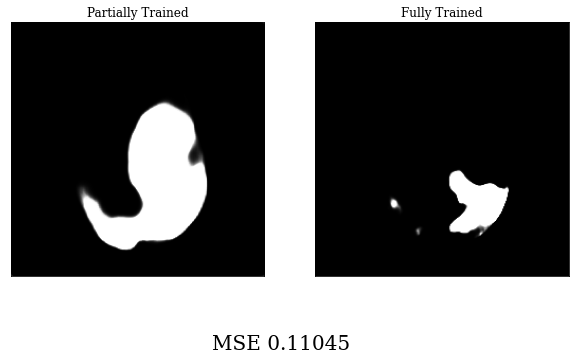

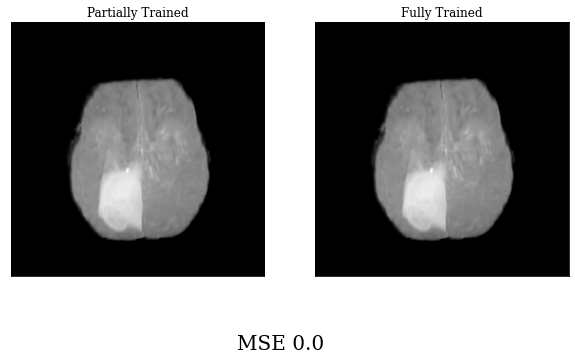

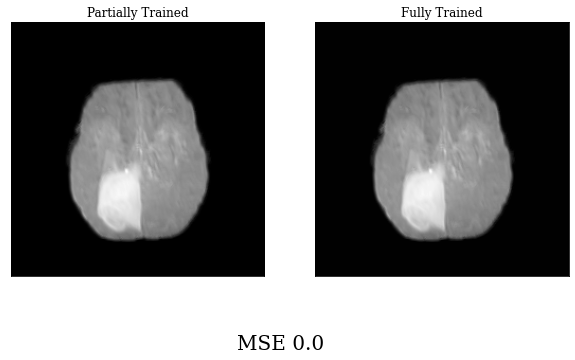

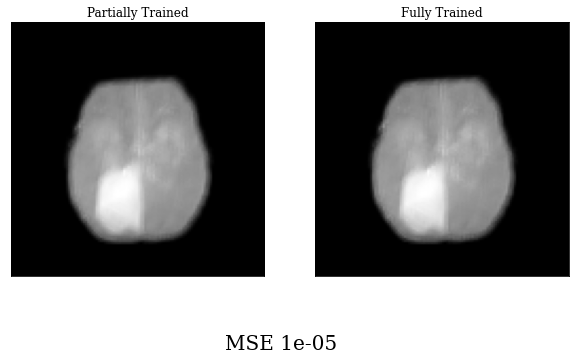

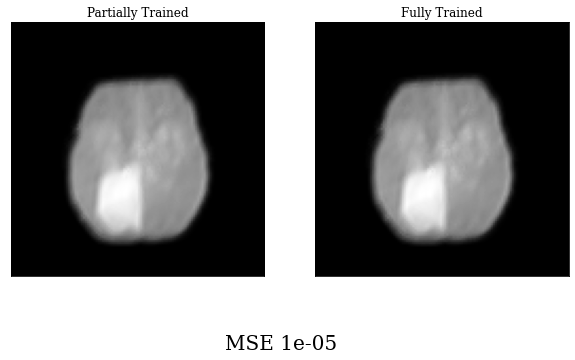

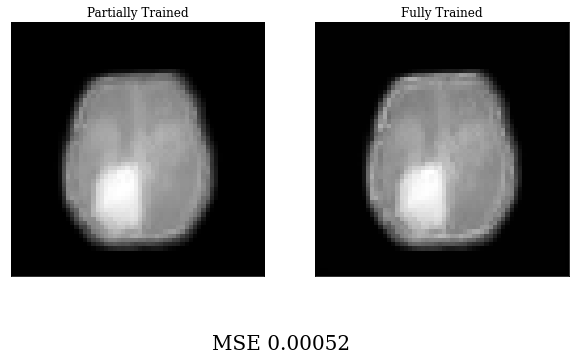

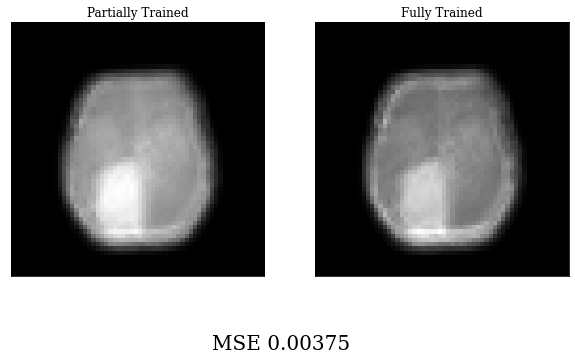

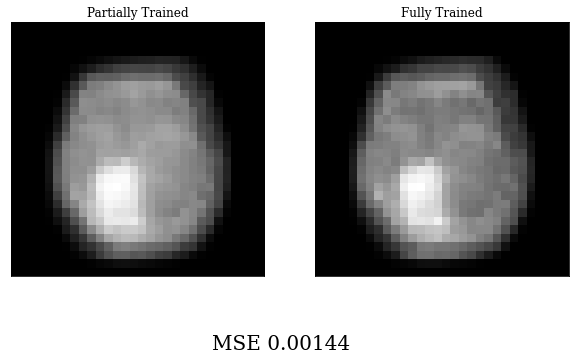

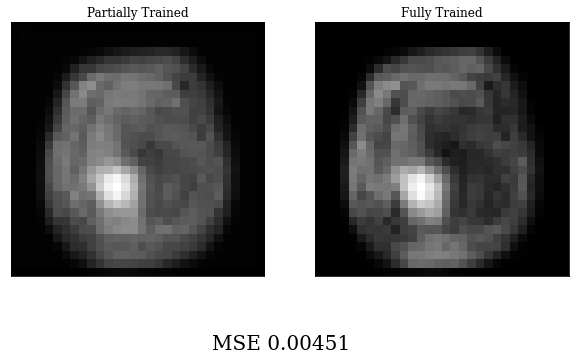

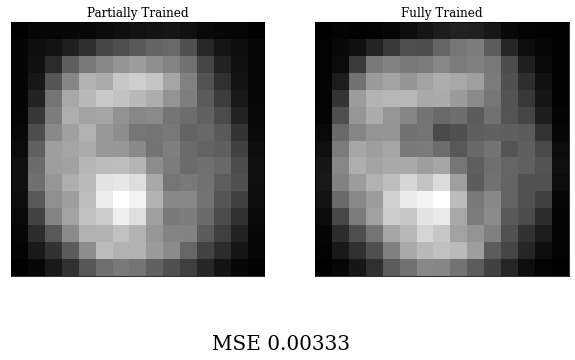

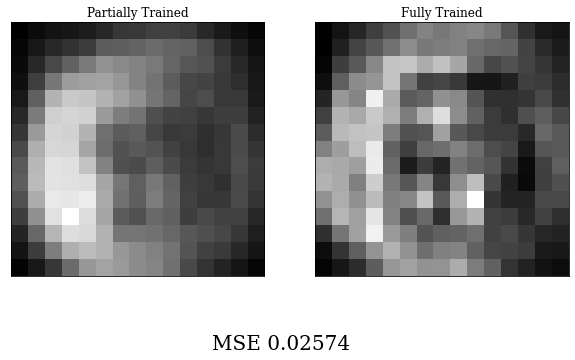

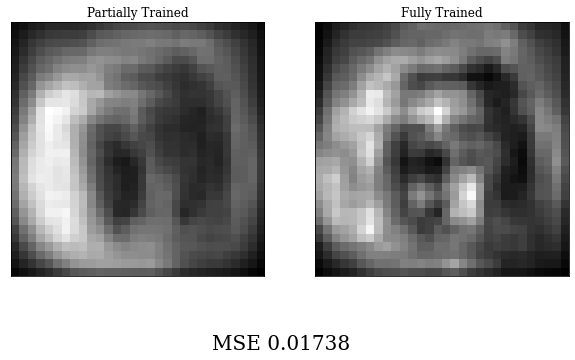

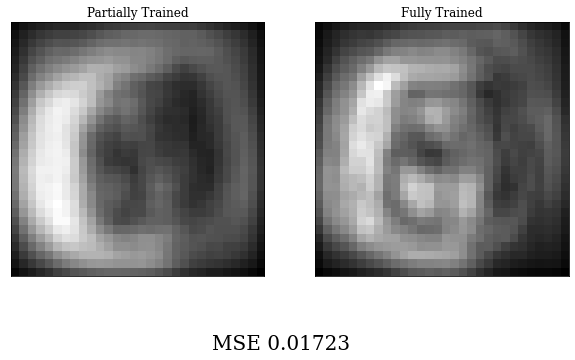

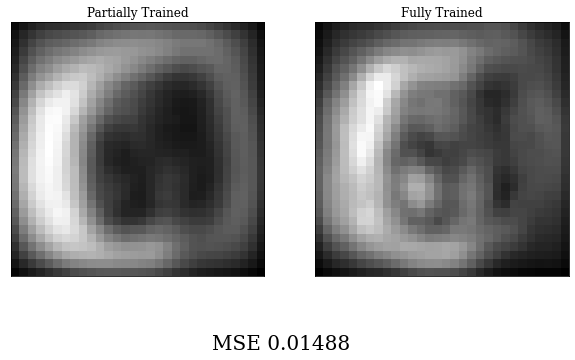

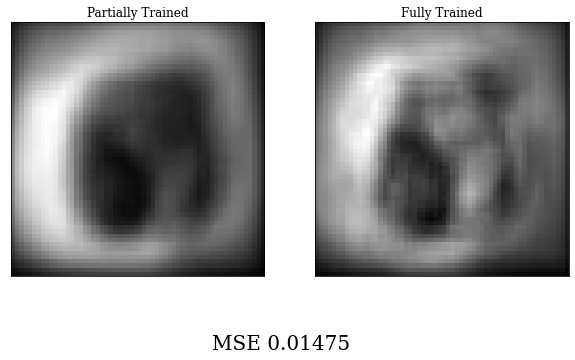

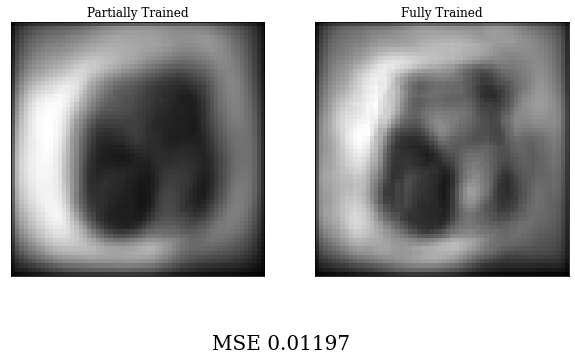

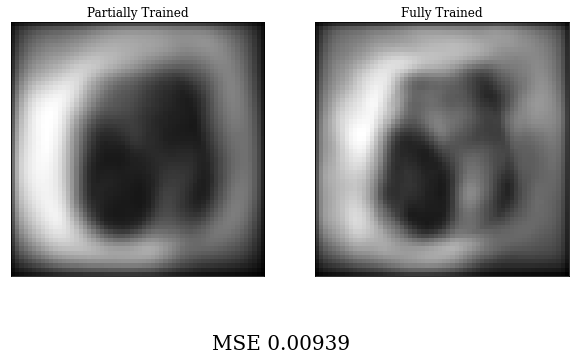

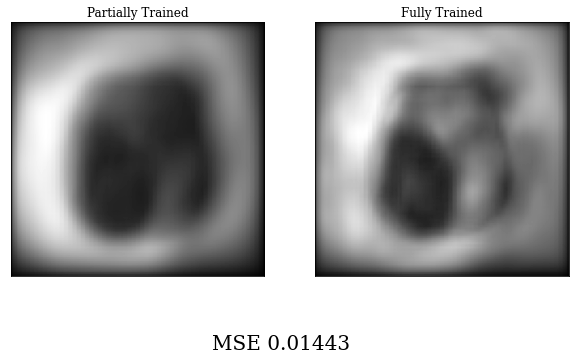

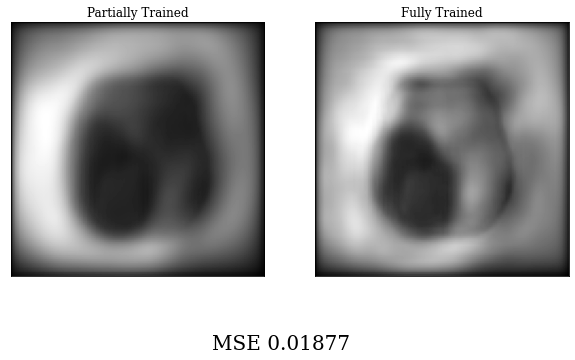

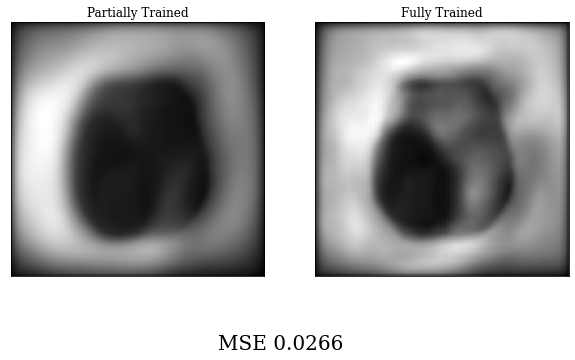

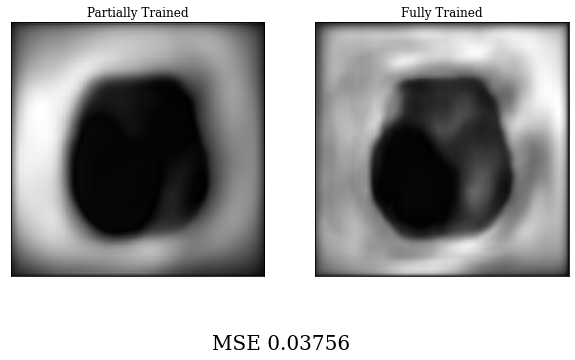

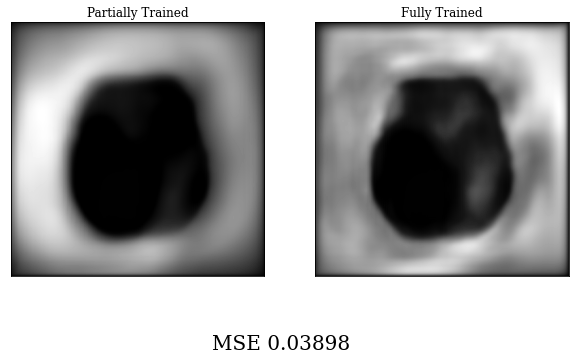

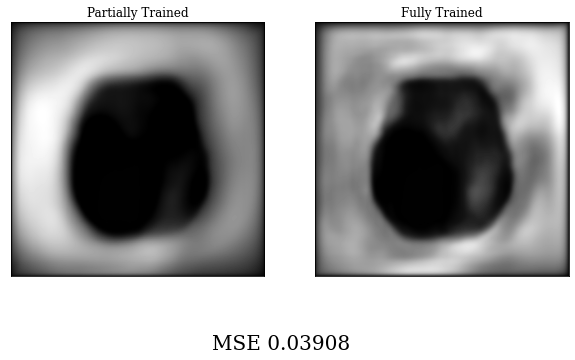

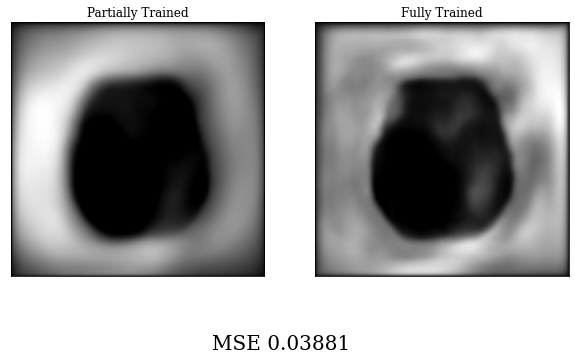

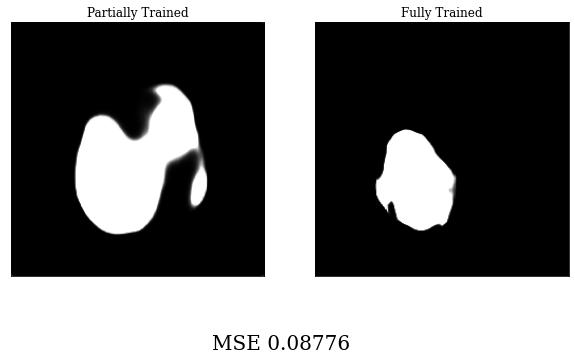

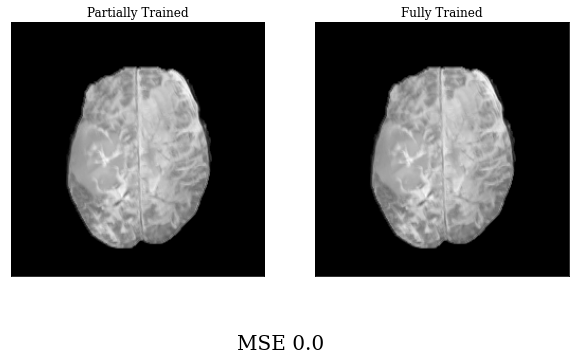

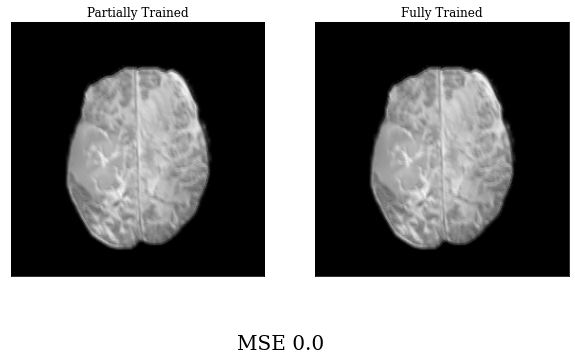

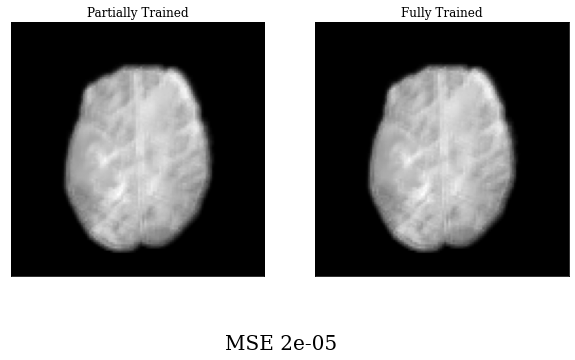

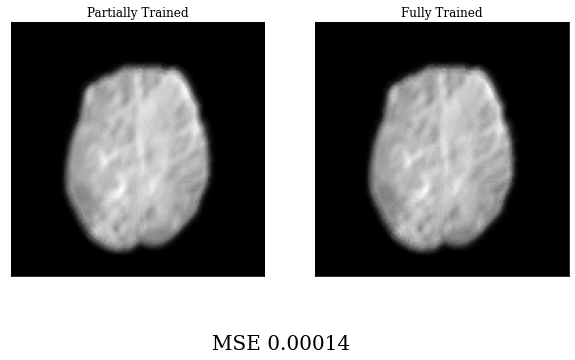

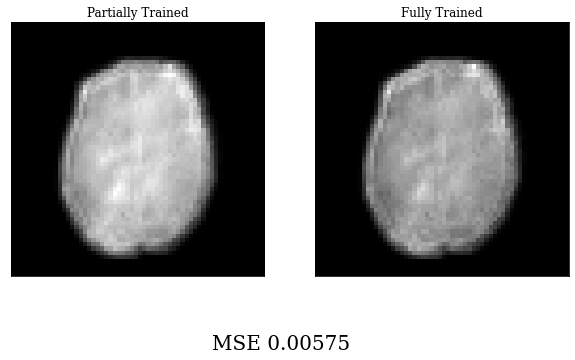

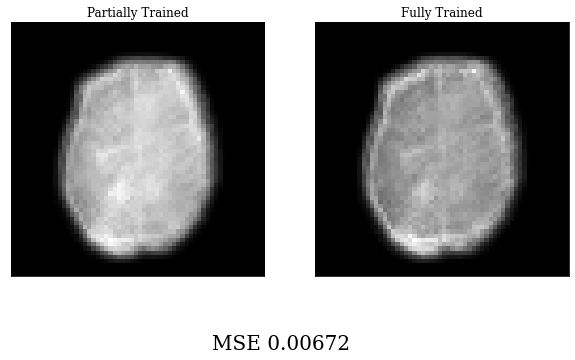

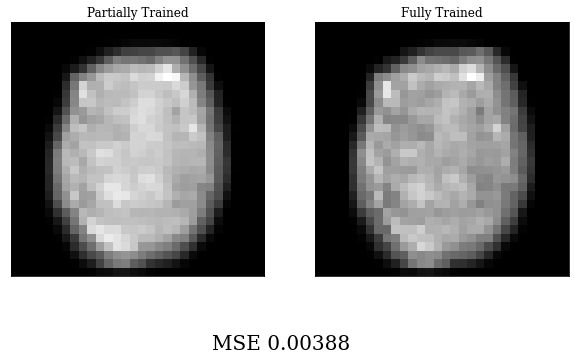

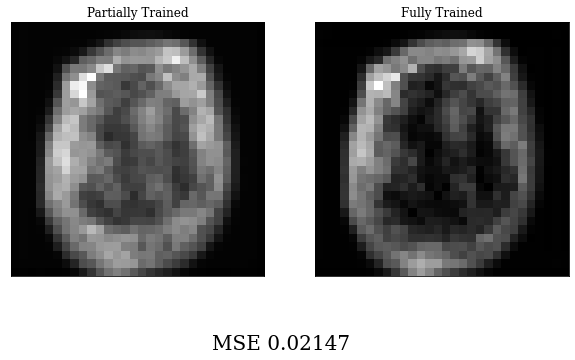

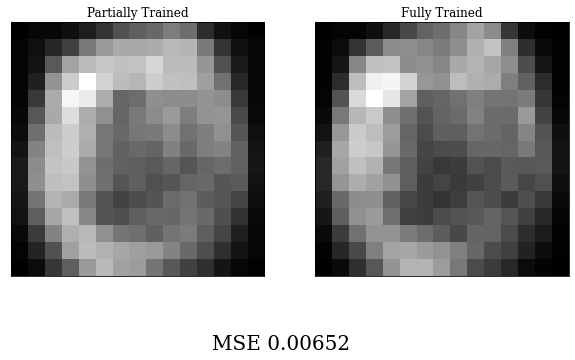

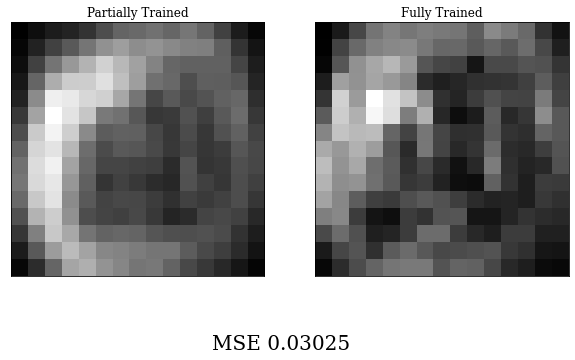

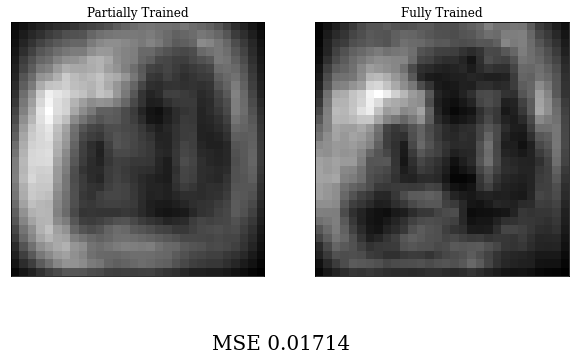

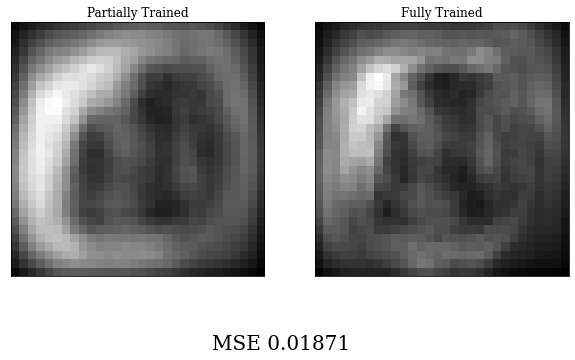

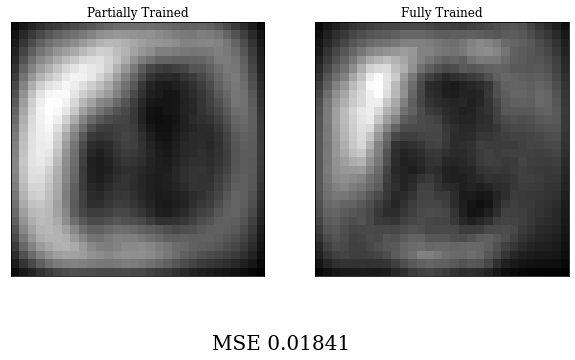

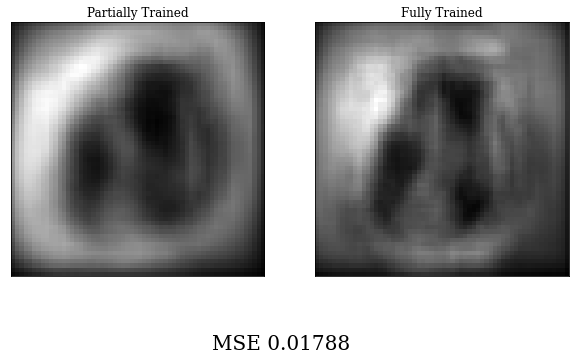

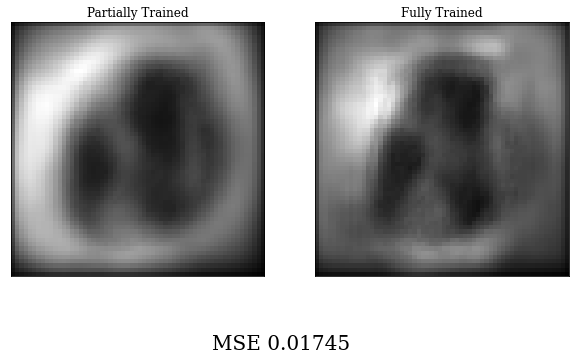

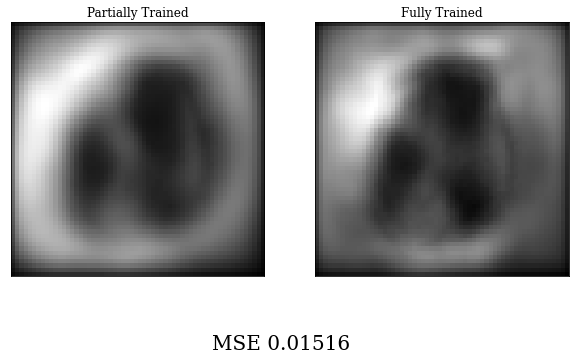

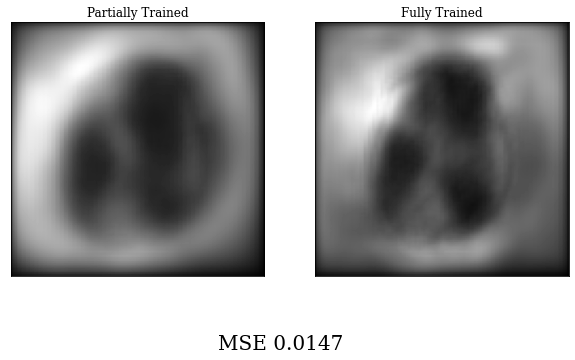

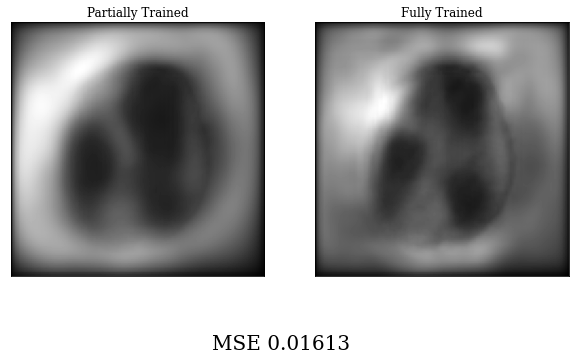

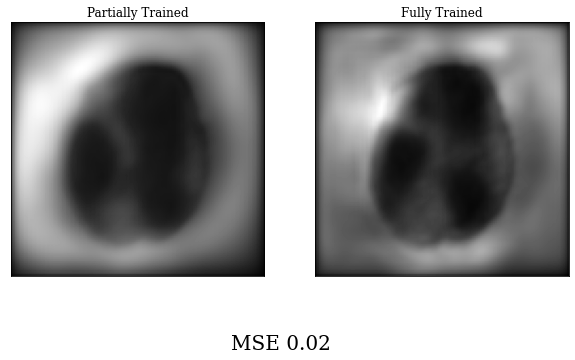

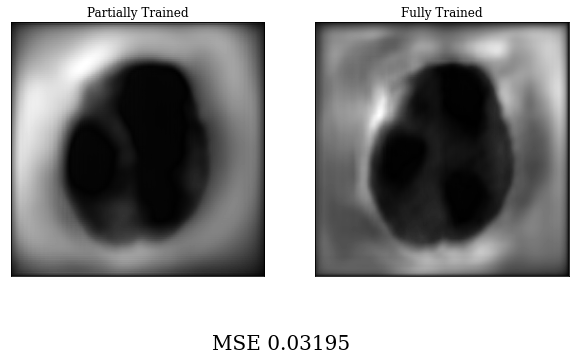

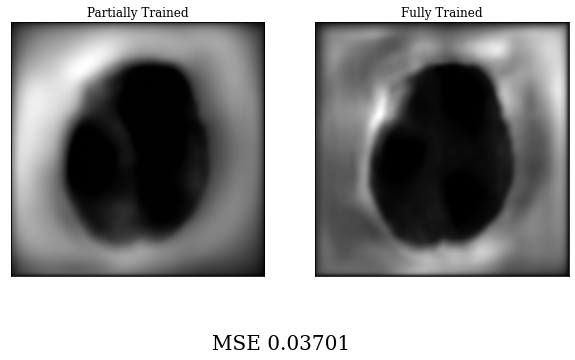

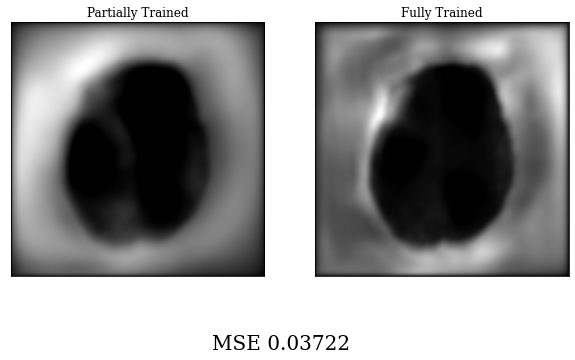

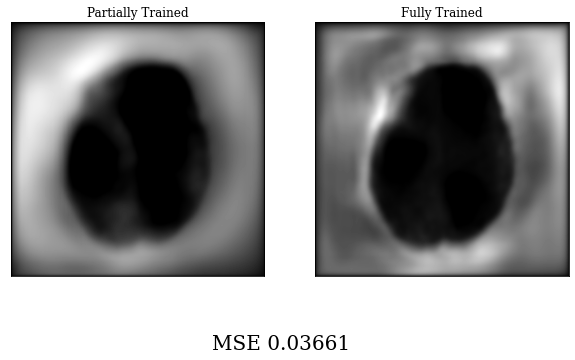

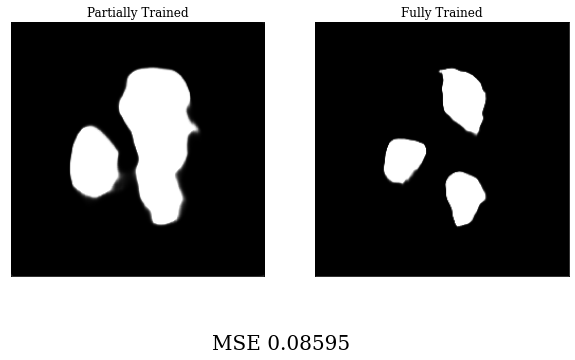

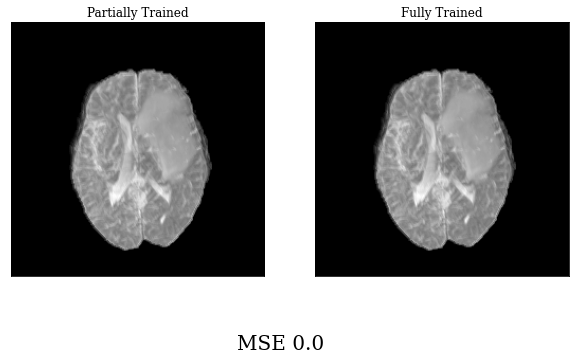

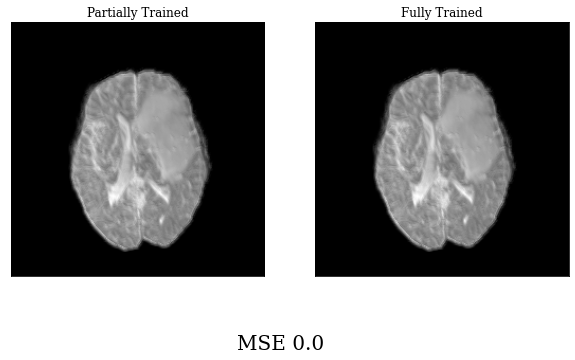

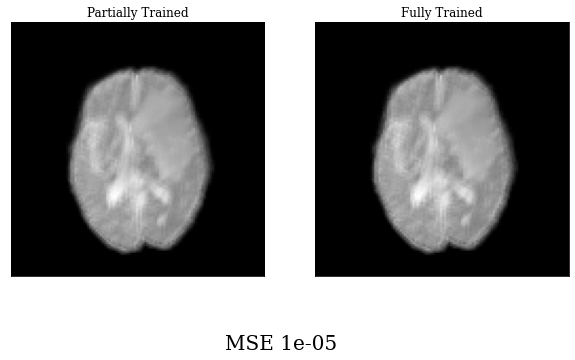

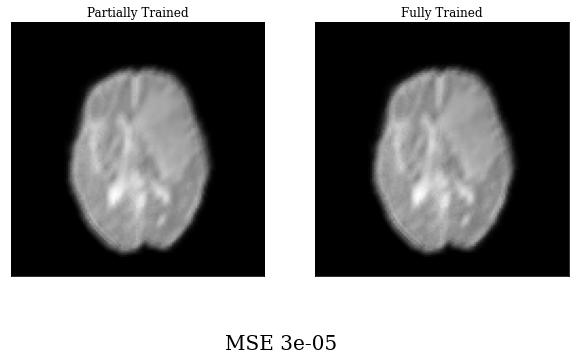

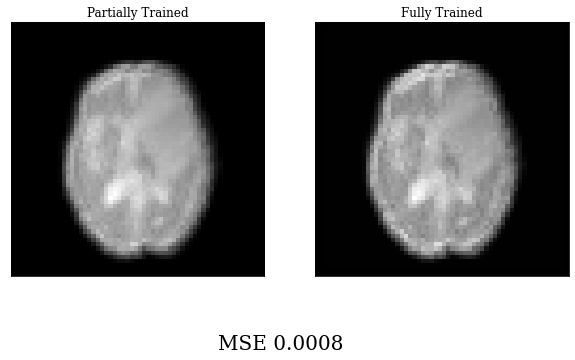

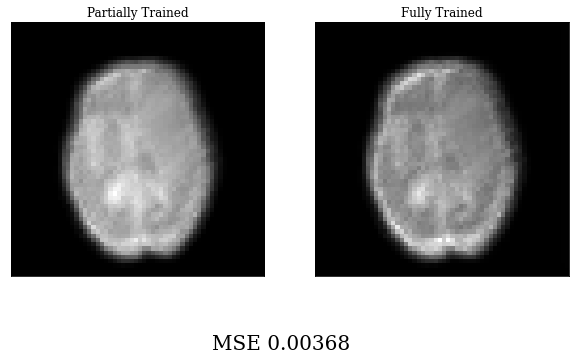

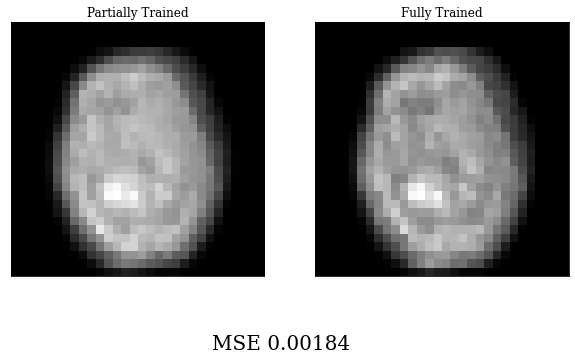

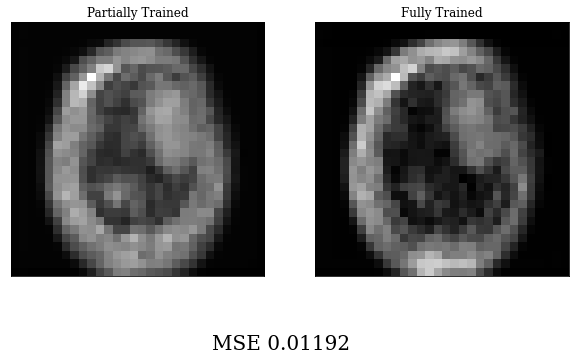

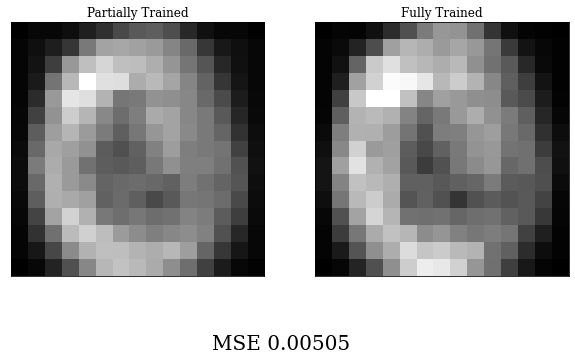

Error in callback <function flush_figures at 0x7fd7006c8b90> (for post_execute):


KeyboardInterrupt: 

In [28]:
get_feat_maps(test_X, layers, good, bad)